
**Autor:** André Garofalo Vaz Junior

**Data:** 27/09/2025

**Dataset:** [Food Delivery Dataset](https://www.kaggle.com/datasets/gauravmalik26/food-delivery-dataset)

---
# Análise Preditiva de Tempo de Entrega em Delivery


## 1. Contexto e Objetivo do Projeto

> A eficiência logística é um pilar fundamental para o sucesso de qualquer serviço de entrega. A capacidade de prever com precisão o tempo de entrega não apenas melhora a satisfação e a confiança do cliente, mas também permite otimizar a alocação de recursos, gerenciar expectativas e identificar gargalos operacionais.

> O objetivo principal deste projeto é desenvolver um modelo de machine learning capaz de prever o tempo de entrega de um pedido de comida em minutos. A variável a ser prevista (alvo) é a **`Time_taken(min)`**. Por se tratar da previsão de um valor contínuo, este é um **problema de regressão**.

> Este notebook documentará o processo completo, desde a análise exploratória e limpeza dos dados, passando pela engenharia de atributos e otimização de modelos, até a interpretação final dos resultados e a extração de insights de negócio.

> O estudo utiliza o "Food Delivery Dataset", um conjunto de dados que simula as operações de um serviço de entrega e disponibilizado no Kaggle através do link: https://www.kaggle.com/datasets/gauravmalik26/food-delivery-dataset


## 2. Dicionário de Dados




 As colunas disponíveis para a análise são:

> * **`ID`**: identificador único do pedido.
> * **`Delivery_person_ID`**: identificador único do entregador.
> * **`Delivery_person_Age`**: idade do entregador.
> * **`Delivery_person_Ratings`**: avaliação média do entregador.
> * **`Restaurant_latitude`**: latitude do restaurante.
> * **`Restaurant_longitude`**: longitude do restaurante.
> * **`Delivery_location_latitude`**: latitude do local de entrega.
> * **`Delivery_location_longitude`**: longitude do local de entrega.
> * **`Order_Date`**: data em que o pedido foi feito.
> * **`Time_Orderd`**: horário em que o pedido foi feito.
> * **`Time_Order_picked`**: horário em que o entregador coletou o pedido.
> * **`Weatherconditions`**: condições climáticas no momento da entrega.
> * **`Road_traffic_density`**: densidade do tráfego no momento da entrega.
> * **`Vehicle_condition`**: condição do veículo do entregador (escala numérica).
> * **`Type_of_order`**: tipo de item pedido (ex: Lanche, Refeição).
> * **`Type_of_vehicle`**: tipo de veículo utilizado na entrega.
> * **`multiple_deliveries`**: número de outras entregas que o entregador estava realizando na mesma rota.
> * **`Festival`**: se a entrega ocorreu durante um festival.
> * **`City`**: tipo de cidade (ex: Urbana, Metropolitana).
> * **`Time_taken(min)`**: **(Variável Alvo)** o tempo, em minutos, entre a coleta do pedido e a sua entrega.

## 3. Hipóteses Iniciais

Antes de iniciar a análise exploratória, as hipóteses que levanto acerca das relações entre as variáveis e o tempo de entrega são:

> * **Distância:** o tempo de entrega deve ter uma forte correlação positiva com a distância entre o restaurante e o cliente.
> * **Condições Externas:** `Road_traffic_density` e `Weatherconditions` devem impactar negativamente a performance. Condições de "Jam" (congestionamento) ou "Adverse" (clima adverso) devem levar a tempos de entrega maiores.
> * **Performance do Entregador:** `Delivery_person_Ratings` deve ter uma correlação negativa com o tempo; entregadores mais bem avaliados tendem a ser mais rápidos. A relação com `Delivery_person_Age` é incerta e será um ponto de investigação.
> * **Complexidade Operacional:** `multiple_deliveries` e o tempo de preparo do pedido (`Time_Order_picked` - `Time_Orderd`) devem ter uma correlação positiva com o tempo total de entrega.

---
# 1. Configuração do Ambiente de Projeto


Realiza a configuração do ambiente de trabalho, sendo as seguintes operações executadas em sequência:

1.  **Sincronização do Repositório:** o repositório Git associado a este projeto é clonado, garantindo que as funções e módulos auxiliares customizados estejam disponíveis para o notebook. Neste projeto, as etapas de `Análise Inicial do Dataset`, `Limpeza e Preparação dos Dados` e `Análise Exploratória dos Dados` utilizam funções desenvolvidas em disciplinas já concluídas desta pós-graduação, sendo armazenadas em uma bilbioteca de módulos customizados;
2.  **Instalação de Dependências:** as bibliotecas Python e suas versões específicas, listadas no arquivo `requirements.txt`, são instaladas no ambiente de execução. O output da instalação é suprimido para manter o relatório conciso;
3.  **Configuração do Ambiente Python:** o diretório de código-fonte (`src/`) do repositório é adicionado ao `sys.path` do sistema, permitindo a importação direta dos módulos customizados. Configurações da biblioteca `pandas` também são ajustadas para otimizar a exibição de dataframes;
4.  **Carregamento do Dataset:** o conjunto de dados de estudo é carregado a partir de uma URL pública e imutável, o que assegura que a fonte de dados seja a mesma entre diferentes execuções e ambientes.

Ao final, um resumo de status é exibido, indicando o sucesso ou a falha de cada uma das etapas executadas.

In [1]:
!pip install -q dython
!pip install -q optuna
!pip install -q catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.6 MB/s eta 0:00:00


In [2]:
# Bibliotecas padrão
import json
import os
import random
import subprocess
import sys
import time

# Manipulação de dados
import numpy as np
import pandas as pd
import scipy.stats as stats
from dython.nominal import associations

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Utilitários
import requests
from tqdm.notebook import tqdm

# Machine Learning
import sklearn
from joblib import Memory
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.metrics import (make_scorer, mean_absolute_error, mean_squared_error, r2_score)
from sklearn.model_selection import (GroupKFold, GroupShuffleSplit, cross_val_score, cross_validate)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import shap
import optuna
import joblib


A variável `EXECUTAR_MODELAGEM_COMPLETA` é utilizada como interruptor para controlar a forma como a etapa de **Modelagem de Dados** é processada. Sendo possível apresentar os valores:

> **`False`:** executa o notebook em **modo rápido**. As etapas computacionalmente intensivas (comparação de modelos e otimização de hiperparâmetros) utilizam os resultados pré-calculados e armazenados na pasta artifacts do repositório;

> **`True`:** Executa o notebook em **modo completo**, recalculando todos os modelos do zero.

In [3]:
EXECUTAR_MODELAGEM_COMPLETA = False

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

print("Python:", sys.version.split()[0])
print("Seed global:", SEED)

Python: 3.12.11
Seed global: 42


In [4]:
# --------------------------------------------
# Configuração do Ambiente de Projeto
# --------------------------------------------
status_log = []

REPO_URL = "https://github.com/andregarofalovaz/pos-grad-datascience.git"
DATA_URL = "https://raw.githubusercontent.com/andregarofalovaz/pos-grad-datascience/refs/heads/main/data/Food%20Delivery%20Dataset.csv"

# 1: Sincronização do repositório
REPO_NAME = REPO_URL.split('/')[-1].replace('.git', '')
try:
    if not os.path.exists(REPO_NAME):
        subprocess.run(['git', 'clone', REPO_URL], check=True, capture_output=True)
    else:
        subprocess.run(['git', 'pull'], cwd=REPO_NAME, check=True, capture_output=True)
    status_log.append("1. Sincronização do Repositório: ✅")
except subprocess.CalledProcessError as e:
    status_log.append("1. Sincronização do Repositório: ❌")
    status_log.append(f"  └── Falha no Git: {e.stderr.decode('utf-8').strip()}")

# 2: Instalação de dependências
requirements_path = os.path.join(REPO_NAME, 'requirements.txt')
try:
    subprocess.run(f"pip install -q -r {requirements_path}", shell=True, check=True)
    status_log.append("2. Instalação de Dependências:   ✅")
except subprocess.CalledProcessError as e:
    status_log.append("2. Instalação de Dependências:   ❌")
    status_log.append(f"  └── Falha no Pip: {e.stderr.strip() if e.stderr else 'Erro desconhecido.'}")

# 3: Importação de bibliotecas personalizadas
try:
    module_path = os.path.join(REPO_NAME, 'src')
    if module_path not in sys.path:
        sys.path.append(module_path)

    from pos_grad_datascience import core, processing
    from pos_grad_datascience.core.utils import display_library_versions
    from pos_grad_datascience.dashboard import UnivariateDashboard

    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    status_log.append("3. Configuração do Ambiente:     ✅")
except Exception as e:
    status_log.append("3. Configuração do Ambiente:   ❌")
    status_log.append(f"  └── Falha na configuração: {str(e)}")

# 4. Carregamento do dataset
try:
    df_raw = pd.read_csv(DATA_URL)
    status_log.append("4. Carregamento do dataset:      ✅")
except Exception as e:
    status_log.append("4. Carregamento do dataset:      ❌")
    status_log.append(f"  └── Falha no carregamento: {str(e)}")

print(f"""
--------------------------------------------
 Configuração do Ambiente de Projeto
--------------------------------------------
""")
for status in status_log:
    print(status)


print(f"""
--------------------------------------------
 Primeiras Linhas do Dataset
--------------------------------------------
""")
df_raw.head(10)


--------------------------------------------
 Configuração do Ambiente de Projeto
--------------------------------------------

1. Sincronização do Repositório: ✅
2. Instalação de Dependências:   ✅
3. Configuração do Ambiente:     ✅
4. Carregamento do dataset:      ✅

--------------------------------------------
 Primeiras Linhas do Dataset
--------------------------------------------



,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30
5,0x9bb4,HYDRES09DEL03,22,4.8,17.431668,78.408321,17.461668,78.438321,11-03-2022,21:20:00,21:30:00,conditions Cloudy,Jam,0,Buffet,motorcycle,1,No,Urban,(min) 26
6,0x95b4,RANCHIRES15DEL01,33,4.7,23.369746,85.339820,23.479746,85.449820,04-03-2022,19:15:00,19:30:00,conditions Fog,Jam,1,Meal,scooter,1,No,Metropolitian,(min) 40
7,0x9eb2,MYSRES15DEL02,35,4.6,12.352058,76.606650,12.482058,76.736650,14-03-2022,17:25:00,17:30:00,conditions Cloudy,Medium,2,Meal,motorcycle,1,No,Metropolitian,(min) 32
8,0x1102,HYDRES05DEL02,22,4.8,17.433809,78.386744,17.563809,78.516744,20-03-2022,20:55:00,21:05:00,conditions Stormy,Jam,0,Buffet,motorcycle,1,No,Metropolitian,(min) 34
9,0xcdcd,DEHRES17DEL01,36,4.2,30.327968,78.046106,30.397968,78.116106,12-02-2022,21:55:00,22:10:00,conditions Fog,Jam,2,Snack,motorcycle,3,No,Metropolitian,(min) 46


---
# 2. Análise Inicial do Dataset



Esta etapa consiste em um diagnóstico preliminar da qualidade dos dados encontrados no dataset de estudo. O objetivo é realizar uma avaliação estruturada a cerca da estrutura do dataset, das suas colunas e das suas features (categóricas e numéricas) para traçar as estratégias inicias de limpeza de dados e identificar oportunidades de otimização.

### 2.1. Análise Estrutural do Dataset
A análise se inicia com uma avaliação da estrutura geral do dataset para quantificar suas dimensões, volume e integridade inicial.

O relatório indica um conjunto de **45.593 registros** e **20 variáveis**, sem duplicatas aparentes. Notavelmente, uma inspeção preliminar dos tipos de dados não acusa valores nulos, porém, a presença de múltiplos `dtypes` do tipo `object` em colunas que deveriam ser numéricas levanta a hipótese de **nulos ocultos**. As próximas etapas focarão em validar esta hipótese e detalhar o plano de limpeza.

In [5]:
global_report = processing.create_global_report(df_raw)
display(global_report)

,MÉTRICA,VALOR
0,Total de Linhas,"45,593"
1,Total de Colunas,20
2,Linhas Duplicadas,0
3,Células Nulas (Total),0
4,% de Células Nulas,0.0%
5,Uso de Memória (KB),"39,617.2 KB"
6,Colunas do tipo 'object',15
7,Colunas do tipo 'float64',4
8,Colunas do tipo 'int64',1


### 2.2. Diagnóstico por Coluna
A análise prossegue para o nível de cada coluna, com o objetivo de inspecionar os tipos de dados, a cardinalidade e amostras de valores para detalhar o plano de limpeza.

A inspeção dos `dtypes` e dos exemplos de valores confirma as hipóteses e indica as seguintes ações de pré-processamento:
1.  **Padronização de Nulos:** a presença da string de texto `'NaN '` em colunas como `Festival` e `City` valida a hipótese de nulos ocultos.
2.  **Limpeza de Strings:** a coluna alvo (`Time_taken(min)`) contém o sufixo `'(min) '` e `Weatherconditions` contém o prefixo `'conditions '`, ambos necessitando de remoção.
3.  **Conversão de Tipos:** colunas numéricas e de data (`DELIVERY_PERSON_AGE`, `ORDER_DATE`, etc.) foram lidas como `object` devido à contaminação por texto e nulos ocultos, exigindo uma conversão posterior.
4.  **Planejamento de Remoção e Manutenção de Colunas:** a coluna `ID` apresenta alta cardinalidade, confirmando seu papel de identificador sem valor preditivo e será removida. A coluna `DELIVERY_PERSON_ID`, por sua vez, será **mantida** nesta fase, pois, apesar de também ser um identificador, ela será utilizada na etapa de modelagem para criar a divisão de dados agrupada e prevenir o *data leakage*.


In [6]:
column_statistics_report = processing.create_column_report(df_raw, num_exemplos=5)
display(column_statistics_report)

,COLUNA,TIPO,QT_NULOS,%_NULOS,QTD_VALORES_UNICOS,%_VALORES_UNICOS,USO_MEMORIA_KB,EXEMPLO_VALORES
0,ID,object,0,0.0,45593,100.0,2491.0,"[0x4607 , 0xb379 , 0x5d6d , 0x7a6a , 0x70a2 ]"
1,Delivery_person_ID,object,0,0.0,1320,2.9,2836.7,"[INDORES13DEL02 , BANGRES18DEL02 , BANGRES19DE..."
2,Delivery_person_Age,object,0,0.0,23,0.1,2274.4,"[37, 34, 23, 38, 32]"
3,Delivery_person_Ratings,object,0,0.0,29,0.1,2307.0,"[4.9, 4.5, 4.4, 4.7, 4.6]"
4,Restaurant_latitude,float64,0,0.0,657,1.4,356.2,"[22.745049, 12.913041, 12.914264, 11.003669, 1..."
5,Restaurant_longitude,float64,0,0.0,518,1.1,356.2,"[75.892471, 77.683237, 77.6784, 76.976494, 80...."
6,Delivery_location_latitude,float64,0,0.0,4373,9.6,356.2,"[22.765049, 13.043041, 12.924264, 11.053669, 1..."
7,Delivery_location_longitude,float64,0,0.0,4373,9.6,356.2,"[75.912471, 77.813237, 77.6884, 77.026494, 80...."
8,Order_Date,object,0,0.0,44,0.1,2626.9,"[19-03-2022, 25-03-2022, 05-04-2022, 26-03-202..."
9,Time_Orderd,object,0,0.0,177,0.4,2531.1,"[11:30:00, 19:45:00, 08:30:00, 18:00:00, 13:30..."


### 2.3. Análise de Cardinalidade e Consistência Categórica
A análise agora foca nas variáveis categóricas para inspecionar sua cardinalidade e a consistência dos seus valores.

O relatório revela três pontos importantes:
1.  **Inconsistência de Strings:** a principal descoberta foi a presença de espaços em branco ao final dos valores em múltiplas colunas (ex: `'High '`, `'No '`). Isso cria categorias duplicadas de forma silenciosa e será corrigido com a remoção desses espaços;
2.  **Baixa Cardinalidade:** todas as variáveis apresentam um número baixo de categorias (entre 3 e 6), o que valida o uso futuro da técnica de `One-Hot Encoding` na etapa de pré-processamento, sem o risco de uma explosão de dimensionalidade;
3.  **Identificação de Natureza Ordinal:** a coluna `ROAD_TRAFFIC_DENSITY` se destaca por possuir uma ordem intrínseca em seus valores (`Low` < `Medium` < `High` < `Jam`). O uso da técnica de `OrdinalEncoder` será aplicada para capturar esta relação hierárquica de forma mais eficiente.

In [7]:
df_colunas_categoricas = df_raw.drop(columns=[
    'ID',
    'Delivery_person_ID',
    'Delivery_person_Age',
    'Delivery_person_Ratings',
    'Order_Date',
    'Time_Orderd',
    'Time_Order_picked',
    'multiple_deliveries',
    'Time_taken(min)'
])

column_values_report = processing.create_unique_values_report(df=df_colunas_categoricas, column_types=['object', 'category'], top_n=None, null_placeholders=["NaN "])
display(column_values_report)

,COLUNA,VALOR_UNICO,CONTAGEM,PERCENTUAL,POSSIVEL_NULO
0,Weatherconditions,conditions Fog,7654,16.8,False
1,Weatherconditions,conditions Stormy,7586,16.6,False
2,Weatherconditions,conditions Cloudy,7536,16.5,False
3,Weatherconditions,conditions Sandstorms,7495,16.4,False
4,Weatherconditions,conditions Windy,7422,16.3,False
5,Weatherconditions,conditions Sunny,7284,16.0,False
6,Weatherconditions,conditions NaN,616,1.4,False
7,Road_traffic_density,NaN,601,1.3,True
8,Road_traffic_density,Low,15477,33.9,False
9,Road_traffic_density,Jam,14143,31.0,False


### 2.4. Análise Estatística de Colunas Numéricas
A etapa final do diagnóstico foca na análise das estatísticas descritivas das variáveis numéricas para validar a sanidade dos dados e identificar a necessidade de transformações.

A inspeção da tabela de resumo confirma:
1.  **Sanidade dos Dados:** os intervalos (mínimo e máximo) para colunas como `DELIVERY_PERSON_AGE` e `TIME_TAKEN_MIN` são plausíveis dentro do contexto do problema.
2.  **Anomalia Pontual:** a coluna `DELIVERY_PERSON_RATINGS` apresenta um valor máximo de `6.0`, o que é uma anomalia em uma provável escala de 1 a 5 e será tratada na limpeza.
3.  **Necessidade de Padronização:** a variação significativa nas escalas entre as diferentes variáveis reforça a necessidade de aplicar uma técnica de padronização (*scaling*) antes do treinamento de modelos lineares.

In [8]:
# 1. Remover colunas não numéricas do dataframe
df_colunas_numericas = df_raw.drop(columns=[
    'ID',
    'Delivery_person_ID',
    'Order_Date',
    'Time_Orderd',
    'Time_Order_picked',
    'Weatherconditions',
    'Road_traffic_density',
    'Type_of_order',
    'Type_of_vehicle',
    'Festival',
    'City'
]).copy()

# 2. Remover os trechos de texto da coluna
df_colunas_numericas['Time_taken(min)'] = df_colunas_numericas['Time_taken(min)'].str.replace(r'\(min\) ', '', regex=True)

# 3. Definir quais colunas precisam de conversão
cols_to_convert = [
    'Delivery_person_Age',
    'Delivery_person_Ratings',
    'multiple_deliveries',
    'Time_taken(min)'
]

# 4. Iterar apenas sobre a lista de colunas a serem convertidas
for col in cols_to_convert:
    df_colunas_numericas[col] = pd.to_numeric(df_colunas_numericas[col].str.strip(), errors='coerce')

# 5. Executar o relatório no dataframe
column_numeric_report = processing.create_numerical_report(df=df_colunas_numericas)
display(column_numeric_report)

,COLUNA,TIPO_ATUAL,VALOR_MINIMO,VALOR_MAXIMO,TIPO_OTIMIZADO,TEM_NEGATIVOS,%_ZEROS,PODE_SER_INTEIRO
0,Delivery_person_Age,float64,15.000000,50.000000,float32,False,0.0,True
1,Delivery_person_Ratings,float64,1.000000,6.000000,float32,False,0.0,False
2,Restaurant_latitude,float64,-30.905562,30.914057,float32,True,8.0,False
3,Restaurant_longitude,float64,-88.366217,88.433452,float32,True,8.0,False
4,Delivery_location_latitude,float64,0.010000,31.054057,float32,False,0.0,False
5,Delivery_location_longitude,float64,0.010000,88.563452,float32,False,0.0,False
6,Vehicle_condition,int64,0.000000,3.000000,int8,False,32.9,False
7,multiple_deliveries,float64,0.000000,3.000000,float32,False,30.9,True
8,Time_taken(min),int64,10.000000,54.000000,int8,False,0.0,False


---
# 3. Limpeza e Preparação dos Dados



Com o plano de ação detalhado pela análise inicial, esta etapa foca na execução sistemática das tarefas de limpeza e preparação. O objetivo é transformar o dataset bruto em uma base de dados íntegra, estruturada e consistente.

### 3.1. Cópia de Segurança do Dataset
Como primeira ação e boa prática fundamental, é criada uma cópia exata do dataframe original. O dataframe `df_raw` permanecerá como uma fonte imutável para consulta, enquanto todas as operações de limpeza e transformação serão aplicadas exclusivamente na nova variável, `df_cleaned`.

In [9]:
df_cleaned = df_raw.copy()

### 3.2. Padronização dos Nomes de Colunas
Para garantir a consistência e a legibilidade do código, todos os nomes de colunas do dataset são padronizados para o formato `UPPER_SNAKE_CASE`. Esta operação elimina ambiguidades (como espaços e caracteres especiais) e permite o acesso seguro às colunas por atributo.

In [10]:
df_cleaned, rename_report = processing.apply_rename(df_cleaned)
display(rename_report)

,NOME_ORIGINAL,NOME_NOVO
0,Delivery_person_ID,DELIVERY_PERSON_ID
1,Delivery_person_Age,DELIVERY_PERSON_AGE
2,Delivery_person_Ratings,DELIVERY_PERSON_RATINGS
3,Restaurant_latitude,RESTAURANT_LATITUDE
4,Restaurant_longitude,RESTAURANT_LONGITUDE
5,Delivery_location_latitude,DELIVERY_LOCATION_LATITUDE
6,Delivery_location_longitude,DELIVERY_LOCATION_LONGITUDE
7,Order_Date,ORDER_DATE
8,Time_Orderd,TIME_ORDERD
9,Time_Order_picked,TIME_ORDER_PICKED


In [11]:
df_cleaned = df_cleaned.rename(columns={'TIME_TAKEN(MIN)': 'TIME_TAKEN_MIN'})

### 3.3. Remoção de Espaços em Branco

Conforme identificado na análise de valores únicos (etapa 1.3), muitas das variáveis categóricas continham espaços em branco no início ou no fim de suas strings. Embora invisíveis, esses caracteres são interpretados como parte do valor, o que cria inconsistências graves. Para resolver isso, apliquei a função `.str.strip()` em todas as colunas do tipo `object`, garantindo a remoção desses espaços e a padronização dos valores.

In [12]:
df_cleaned, strip_string_report = processing.apply_strip_strings(df_cleaned)
display(strip_string_report)

,COLUNA,CELULAS_ALTERADAS
0,ID,45593
1,DELIVERY_PERSON_ID,45593
2,DELIVERY_PERSON_AGE,1854
3,DELIVERY_PERSON_RATINGS,1908
4,TIME_ORDERD,1731
5,ROAD_TRAFFIC_DENSITY,45593
6,TYPE_OF_ORDER,45593
7,TYPE_OF_VEHICLE,45593
8,MULTIPLE_DELIVERIES,993
9,FESTIVAL,45593


### 3.4. Padronização de Valores Nulos

Os valores ausentes no dataset estavam representados de forma inconsistente, como a string de texto `'NaN'`. Esta etapa não tem o objetivo de realizar a imputação, mas sim garantir que todos os valores ausentes sejam representados da maneira padrão que as bibliotecas de análise de dados esperam: `np.nan`.

In [13]:
df_cleaned, report_null_substitution = processing.apply_standardize_nulls(df_cleaned, null_placeholders=["NaN"])
display(report_null_substitution)

,COLUNA,QT_NULOS_ANTES,QT_NULOS_DEPOIS,%_NULOS_DEPOIS,COLUNA_AFETADA
0,ID,0,0,0.0000,False
1,DELIVERY_PERSON_ID,0,0,0.0000,False
2,DELIVERY_PERSON_AGE,0,1854,4.0664,True
3,DELIVERY_PERSON_RATINGS,0,1908,4.1849,True
4,RESTAURANT_LATITUDE,0,0,0.0000,False
5,RESTAURANT_LONGITUDE,0,0,0.0000,False
6,DELIVERY_LOCATION_LATITUDE,0,0,0.0000,False
7,DELIVERY_LOCATION_LONGITUDE,0,0,0.0000,False
8,ORDER_DATE,0,0,0.0000,False
9,TIME_ORDERD,0,1731,3.7966,True


### 3.5. Limpeza de Padrões de Texto Específicos

Esta subetapa foca na remoção de padrões de texto específicos que estão presentes repetitivamente em colunas numéricas e categóricas, impedindo a correta conversão e interpretação de seus tipos de dados.

Foram executadas as seguintes operações de substituição:
1.  Na coluna `TIME_TAKEN_MIN`, o sufixo textual '(min)' foi removido para permitir sua conversão para um tipo numérico inteiro;
2.  Na coluna `WEATHERCONDITIONS`, o prefixo 'conditions ' foi removido para padronizar e simplificar os nomes das categorias climáticas.

In [14]:
df_cleaned['TIME_TAKEN_MIN'] = df_cleaned['TIME_TAKEN_MIN'].str.replace(r'\(min\) ', '', regex=True)
df_cleaned['WEATHERCONDITIONS'] = df_cleaned['WEATHERCONDITIONS'].str.replace('conditions ', '')

### 3.6. Mapeamento de Valores (Correção de Anomalias)

Esta subetapa realiza uma correção pontual de um valor não pertencente ao intervalo esperado para notas de avaliação.

Utilizando a função apply_value_mapping, o valor '6.0', que estava fora da escala esperada para a coluna `DELIVERY_PERSON_RATINGS`, foi corrigido para '5.0'.

In [15]:
mapping = {
    'DELIVERY_PERSON_RATINGS': {
        '6': '5'
    }
}

df_cleaned, report_value_mapping = processing.apply_value_mapping(df_cleaned, mapping_dict=mapping)
display(report_value_mapping)

,COLUNA_AFETADA,VALOR_ORIGINAL,VALOR_NOVO,QUANTIDADE_ALTERACOES
0,DELIVERY_PERSON_RATINGS,6,5,53


### 3.7. Otimização dos Tipos de Dados

Esta etapa possui dois objetivos: reduzir o consumo de memória do dataframe e garantir que cada variável esteja representada com o tipo semanticamente correto. As principais otimizações foram:

1.  **Conversão para Categoria:** colunas de texto com baixa cardinalidade (como `WEATHERCONDITIONS` e `CITY`) foram convertidas para o tipo `category`, que é muito mais eficiente em memória do que `object`;
2.  **Otimização Numérica:** colunas de coordenadas foram convertidas para `float32`, e contagens como `DELIVERY_PERSON_AGE` e `VEHICLE_CONDITION` foram convertidas para tipos inteiros de menor porte (como `Int8`), sem perda de informação;
3.  **Conversão para Data:** a coluna `ORDER_DATE` foi convertida para o tipo `datetime` para habilitar a extração de features como dia da semana na próxima etapa;
4.  **Manutenção Estratégica de Horários:** as colunas `TIME_ORDERD` e `TIME_ORDER_PICKED` foram mantidas como `string` para serem combinadas com `ORDER_DATE` a fim de se calcular o tempo de preparo do pedido.

In [16]:
type_mapping = {
    'ID': 'string',
    'DELIVERY_PERSON_ID': 'string',

    'DELIVERY_PERSON_AGE': 'Int8',
    'MULTIPLE_DELIVERIES': 'Int8',
    'TIME_TAKEN_MIN': 'Int8',
    'VEHICLE_CONDITION': 'Int8',

    'DELIVERY_PERSON_RATINGS': 'float32',
    'RESTAURANT_LATITUDE': 'float32',
    'RESTAURANT_LONGITUDE': 'float32',
    'DELIVERY_LOCATION_LATITUDE': 'float32',
    'DELIVERY_LOCATION_LONGITUDE': 'float32',

    'WEATHERCONDITIONS': 'category',
    'ROAD_TRAFFIC_DENSITY': 'category',
    'TYPE_OF_ORDER': 'category',
    'TYPE_OF_VEHICLE': 'category',
    'FESTIVAL': 'category',
    'CITY': 'category',

    'ORDER_DATE': 'datetime',
    'TIME_ORDERD': 'string',
    'TIME_ORDER_PICKED': 'string'
}

df_cleaned, report_data_types = processing.apply_data_types(df_cleaned, type_mapping)
display(report_data_types)

,NOME_COLUNA,TIPO_ORIGINAL,TIPO_DESEJADO,STATUS,MENSAGEM_ERRO,TIPO_FINAL
0,ID,object,string,Sucesso,,string
1,DELIVERY_PERSON_ID,object,string,Sucesso,,string
2,DELIVERY_PERSON_AGE,object,Int8,Sucesso,,Int8
3,DELIVERY_PERSON_RATINGS,object,float32,Sucesso,,float32
4,RESTAURANT_LATITUDE,float64,float32,Sucesso,,float32
5,RESTAURANT_LONGITUDE,float64,float32,Sucesso,,float32
6,DELIVERY_LOCATION_LATITUDE,float64,float32,Sucesso,,float32
7,DELIVERY_LOCATION_LONGITUDE,float64,float32,Sucesso,,float32
8,ORDER_DATE,object,datetime,Sucesso,,datetime64[ns]
9,TIME_ORDERD,object,string,Sucesso,,string


In [17]:
# Converte a string 'hh:mm:ss' para um objeto de duração (timedelta)
df_cleaned['TIME_ORDERD'] = pd.to_timedelta(df_cleaned['TIME_ORDERD'], errors='coerce')
df_cleaned['TIME_ORDER_PICKED'] = pd.to_timedelta(df_cleaned['TIME_ORDER_PICKED'], errors='coerce')

---
# 4. Análise Exploratória dos Dados

In [18]:
df_analysis = df_cleaned.copy()

### 4.1 Análise Univariada

In [19]:
dashboard_univariado = UnivariateDashboard(df_analysis)
dashboard_univariado.display()




> `DELIVERY_PERSON_AGE`: a variável apresenta uma assimetria à direita, com 50% dos entregadores concentrados entre **25 e 35 anos** e uma idade mediana de **30 anos**. Os valores estão contidos em um intervalo de **15 a 50 anos**, o que é considerado plausível para o contexto do problema. A distribuição, embora não normal, é coerente com o negócio e não exige transformações prévias para os modelos baseados em árvore planejados;

> `DELIVERY_PERSON_RATINGS`: a variável apresenta uma assimetria a esquerda, com uma concentração de avaliações entre **4,6 e 4,9**. A avaliação mediana é de 4.7, indicando que a maioria dos entregadores é bem avaliada. A distribuição confirma que avaliações muito baixas representam um sinal forte e distinto no dataset;

> `MULTIPLE_DELIVERIES`: a variável é discreta e exibe uma concentração em valores baixos, como 0 (nenhuma entrega adicional) e 1, representando 75% de todas as entregas;

> **Coordenadas Geográficas (`*_LATITUDE`, `*_LONGITUDE`):** a análise univariada isolada das quatro colunas oferece insights limitados. Suas distribuições apenas refletem posições geográficas da operação e dos clientes, sem uma correlação direta com o tempo de entrega. A principal hipótese é que a **distância** entre elas poderá ter um sinal preditivo significativo e por isso ganhará atenção na próxima etapa de engenharia de atributos;

> `WEATHERCONDITIONS`: a variável apresenta distribuições muito similares entre as seis condições climáticas, cada uma representando aproximadamente 16-17% do total de entregas. Também observa-se a presença de 616 valores nulos, que correspondem a 1,4% do dataset;

> `ROAD_TRAFFIC_DENSITY`: a variável apresenta uma boa distribuição entre as categorias, caracterizando um contexto com muitos exemplos que favorece o aprendizado. Os valores desta coluna possuem uma ordem intrínseca e clara de intensidade (Low < Medium < High < Jam). A tabela confirma a presença de 601 valores ausentes, correspondendo a 1.3% do dataset;

> `VEHICLE_CONDITION`: a variável busca entender sua distribuição e estabelecer uma premissa de trabalho sobre o significado de seus valores para a modelagem. A coluna é do tipo inteira e discreta, a frequência dos níveis 0, 1 e 2 é similar, enquanto o nível 3 é o mais raro. Como a documentação do dataset é omissa, adoto a premissa de que a variável representa uma escala ordinal, onde um valor maior indica uma condição pior (por exemplo, 0=Excelente, 3=Ruim). Esta hipótese será validada na análise bivariada;

> `TYPE_OF_ORDER`: a variável apresenta distribuição quase perfeitamente uniforme entre as suas quatro categorias e não apresenta valores ausentes. Esta distribuição configura um cenário ideal para o aprendizado do modelo, onde o mesmo poderá aprender o padrão associado a cada tipo de pedido sem o risco de criar um viés em favor de uma categoria menos frequente;

> `TYPE_OF_VEHICLE`: a variável apresenta uma distribuição desbalanceada, com uma dominância de motorcycle. As categorias electric_scooter e bicycle são raras no conjunto de dados e durante a análise bivariada avaliaremos a possibilidade de uní-las em uma única categoria;

> `FESTIVAL`: a variável apresenta um desbalanceamento extremo entre as duas categorias. Sendo a maioria das entregas ocorrendo em dias normais (No) e minoria ocorrendo durante um festival (Yes). A coluna possui 228 valores nulos, correspondendo a 0.5% do dataset;

> `CITY`: a variável apresenta um forte desbalanceamento, sendo a categoria 'Metropolitian' dominante, enquanto a 'Urban' é a segunda e a 'Semi-Urban' é extremamente rara. A coluna possui 1200 valores nulos, o que corresponde a 2.6% do dataset. Este desbalanceamento extremo implica em uma modelagem que aprende mais sobre os padrões de áreas metropolitanas e urbanas, sendo os resultados para áreas semi-urbanas menos confiáveis devido a escassez de dados;

> `TIME_TAKEN_MIN`: a variável apresenta um histograma com uma leve assimetria a direita, confirmada pela proximidade de valores de sua mediana (26) e média (26,29). Seus valores se concentram em entregas de 20 e 35 minutos, sendo também observados valores limites mínimo de 10 e máximo de 54 minutos. O comportamento da variável sendo de baixa assimetria indica que não será necessário realizar transformação logarítmica para que os modelos performem bem.



### 4.2 Análise Multivariada

/usr/local/lib/python3.12/dist-packages/dython/nominal.py:632: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  lambda col: col.view(np.int64), axis=0


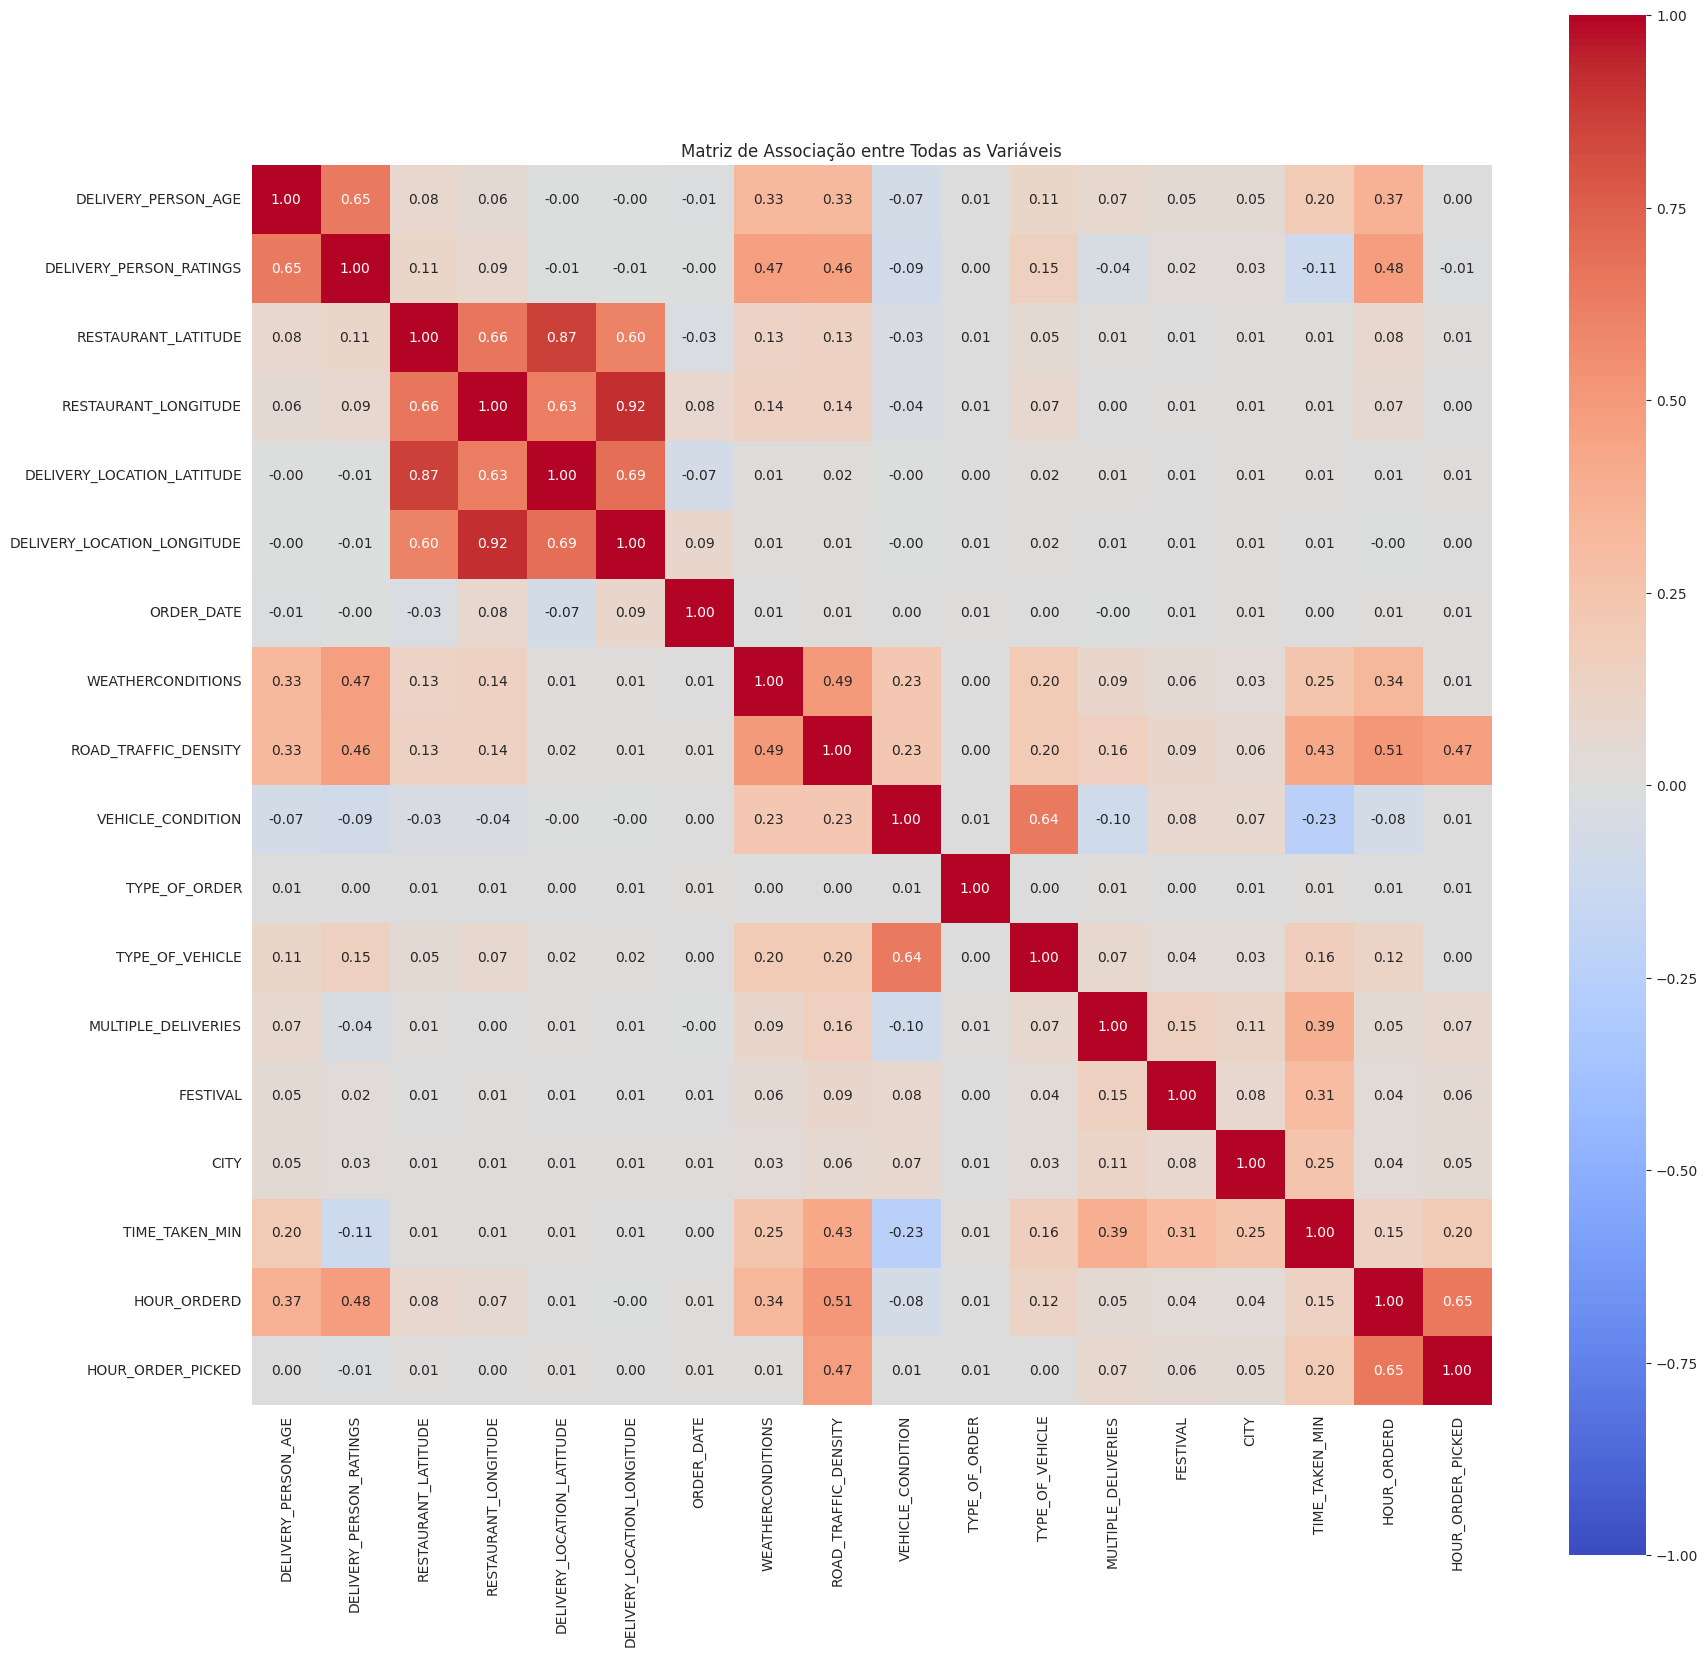

In [20]:
# 1. Engenharia de atributos temporária para a análise
time_cols = ['TIME_ORDERD', 'TIME_ORDER_PICKED']
for col in time_cols:
    new_col_name = col.replace('TIME_', 'HOUR_')
    df_analysis[new_col_name] = (
        pd.to_timedelta(df_analysis[col], errors='coerce').dt.seconds // 3600
    )

# 2. Remove as colunas originais de tempo e os IDs, que não são relevantes para a associação.
cols_to_drop_for_assoc = ['ID', 'DELIVERY_PERSON_ID', 'TIME_ORDERD', 'TIME_ORDER_PICKED']
df_analysis.drop(columns=cols_to_drop_for_assoc, inplace=True)

# 3. Cálculo e Geração do Heatmap de Associações
assoc_results = associations(
    df_analysis,
    nominal_columns='auto',
    figsize=(20, 20),
    cmap='coolwarm',
    title='Matriz de Associação entre Todas as Variáveis'
)



Esta etapa busca entender as relações existentes entre cada par de colunas existente no dataset. Para esta tarefa, foi utilizada a biblioteca `dython`, que calcula uma **matriz de associação** utilizando o teste estatístico apropriado para cada par de variáveis.

O heatmap resultante mostra a força da associação em uma escala de 0 (sem associação) a +/- 1 (associação perfeita). Esta etapa foi intencionalmente disposta antes da análise bivariada para que fosse possível identificar primeiro quais pares de variáveis apresentam correlação notáveis.

As principais descobertas foram:

> 1.  **Forte Associação com o Alvo:** a variável alvo, `TIME_TAKEN_MIN`, mostra as associações mais fortes com `DELIVERY_PERSON_RATINGS`, `DELIVERY_PERSON_AGE`, `ROAD_TRAFFIC_DENSITY` e `MULTIPLE_DELIVERIES`;

> 2.  **Relações entre Features:** observa-se uma associação moderada entre `TIME_ORDERED` e `ROAD_TRAFFIC_DENSITY`, e também entre `VEHICLE_CONDITION` e `TYPE_OF_VEHICLE`. Essas relações entre as features preditivas serão implicitamente modeladas pelos algoritmos;

> 3.  **Confirmação das Coordenadas:** as colunas de latitude e longitude mostram uma associação quase perfeita entre si (`1.00`), mas baixa associação com as outras variáveis. Isso confirma a decisão de não usá-las diretamente, sendo necessário usá-las como forma de extração da feature de distância.

### 4.3 Análise Bivariada


##### Tempo de Entrega vs. Avaliação do Entregador

> O gráfico de dispersão e a linha de regressão revelam a tendência de que, em média, avaliações mais altas estão associadas a tempos de entrega menores. A alta dispersão dos pontos, no entanto, indica que a avaliação sozinha possui um poder preditivo limitado, mas ainda assim representa um sinal útil para o modelo.

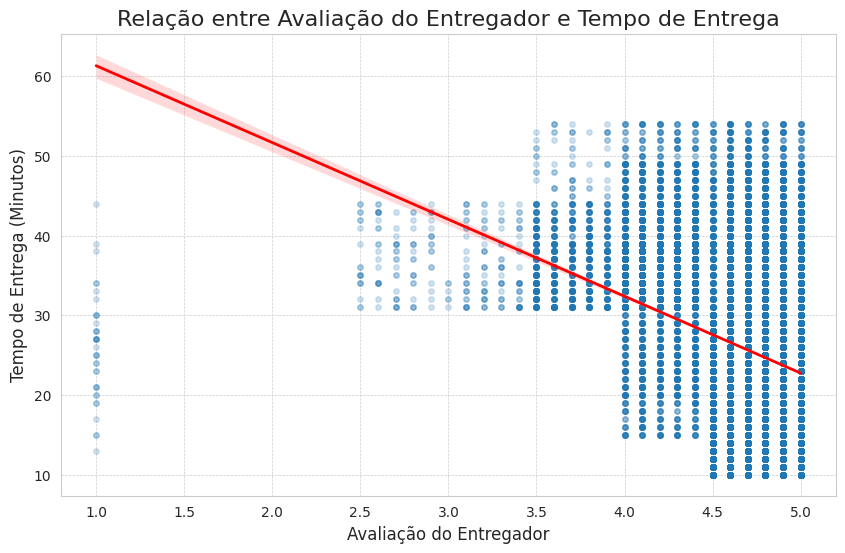

In [21]:
plt.figure(figsize=(10, 6))
sns.regplot(
    data=df_cleaned,
    x='DELIVERY_PERSON_RATINGS',
    y='TIME_TAKEN_MIN',
    scatter_kws={'alpha': 0.2, 's': 15},
    line_kws={'color': 'red', 'linewidth': 2}
)

plt.title('Relação entre Avaliação do Entregador e Tempo de Entrega', fontsize=16)
plt.xlabel('Avaliação do Entregador', fontsize=12)
plt.ylabel('Tempo de Entrega (Minutos)', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

##### Tempo de Entrega vs. Idade do Entregador

> O gráfico de dispersão e a linha de regressão revelam a tendência de que, em média, o tempo de entrega aumenta ligeiramente com o aumento da idade do entregador. A alta dispersão dos pontos, no entanto, indica que a avaliação sozinha possui um poder preditivo limitado, mas ainda assim representa um sinal útil para o modelo.

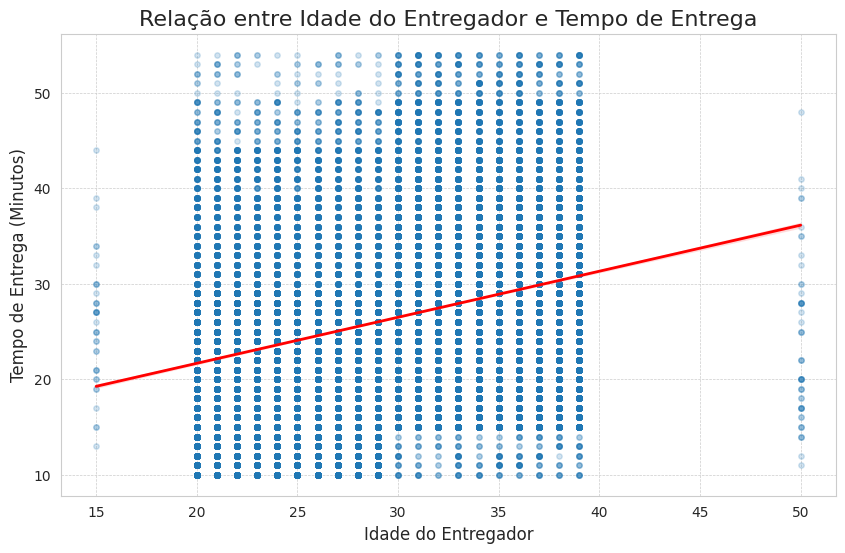

In [22]:
plt.figure(figsize=(10, 6))
sns.regplot(
    data=df_cleaned,
    x='DELIVERY_PERSON_AGE',
    y='TIME_TAKEN_MIN',
    scatter_kws={'alpha': 0.2, 's': 15},
    line_kws={'color': 'red', 'linewidth': 2}
)

plt.title('Relação entre Idade do Entregador e Tempo de Entrega', fontsize=16)
plt.xlabel('Idade do Entregador', fontsize=12)
plt.ylabel('Tempo de Entrega (Minutos)', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

##### Tempo de Entrega vs. Múltiplas Entregas

> O boxplot indica que a mediana do tempo de entrega aumenta consistentemente a cada entrega adicional inclusa na rota. O gráfico confirma que a variavel é um preditor de alto impacto para o modelo.

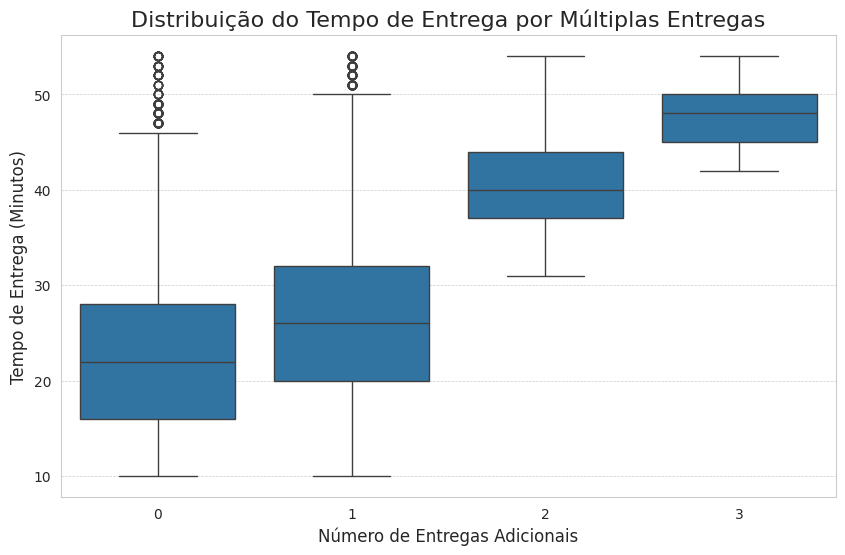

In [23]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_cleaned,
    x='MULTIPLE_DELIVERIES',
    y='TIME_TAKEN_MIN'
)

plt.title('Distribuição do Tempo de Entrega por Múltiplas Entregas', fontsize=16)
plt.xlabel('Número de Entregas Adicionais', fontsize=12)
plt.ylabel('Tempo de Entrega (Minutos)', fontsize=12)
plt.grid(True, axis='y', linestyle='--', linewidth=0.5)
plt.show()

##### Tempo de Entrega vs. Densidade do Tráfego

> O boxplot indica que a mediana do tempo de entrega aumenta consistentemente a medida que a densidade do trânsito piora. A condição 'Jam', além de apresentar a mediana mais alta, também apresenta maior dispersão da valores, indicando maior imprevisibilidade. O gráfico confirma que a variavel é um preditor de alto impacto para o modelo.

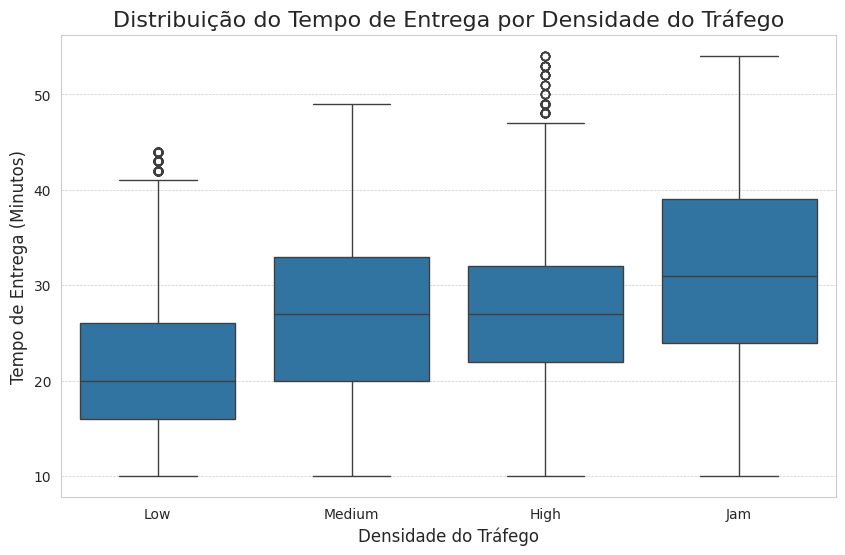

In [24]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_cleaned,
    x='ROAD_TRAFFIC_DENSITY',
    y='TIME_TAKEN_MIN',
    order=['Low', 'Medium', 'High', 'Jam']
)

plt.title('Distribuição do Tempo de Entrega por Densidade do Tráfego', fontsize=16)
plt.xlabel('Densidade do Tráfego', fontsize=12)
plt.ylabel('Tempo de Entrega (Minutos)', fontsize=12)
plt.grid(True, axis='y', linestyle='--', linewidth=0.5)
plt.show()

##### Densidade do Tráfego vs. Tipo de Cidade

> O heatmap revela para as áreas `Metropolitian` e `Urban`, que as condições de trânsito `Low` e `Jam` são as mais comuns, respectivamente. De forma não esperada, a condição mais frequente em áreas `Semi-Urban` é a `Jam`. Possivelmente este comportamento é devido a baixa amostragem desta categoria, sendo este um padrão pouco confiável. Isso reforça a conclusão de que o modelo terá baixa confiabilidade ao fazer previsões para a categoria `Semi-Urban`.

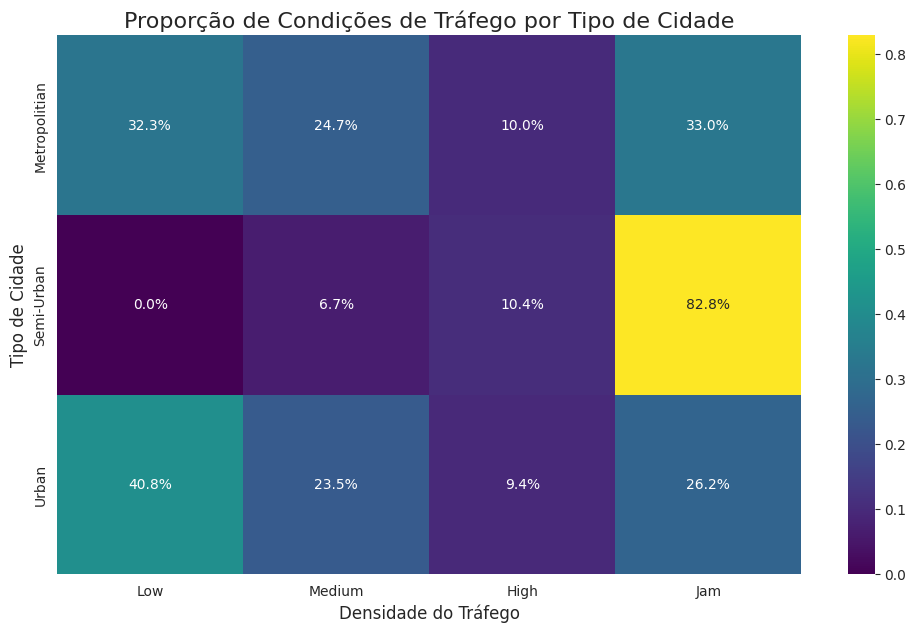

In [25]:
traffic_order = ['Low', 'Medium', 'High', 'Jam']

# Criamos a tabela de contingência
crosstab_proportions = pd.crosstab(
    df_cleaned['CITY'],
    df_cleaned['ROAD_TRAFFIC_DENSITY'],
    normalize='index'
)

# Reordenamos as colunas da tabela antes de plotar
crosstab_ordered = crosstab_proportions[traffic_order]

plt.figure(figsize=(12, 7))
sns.heatmap(
    crosstab_ordered,
    annot=True,
    cmap='viridis',
    fmt='.1%'
)

plt.title('Proporção de Condições de Tráfego por Tipo de Cidade', fontsize=16)
plt.xlabel('Densidade do Tráfego', fontsize=12)
plt.ylabel('Tipo de Cidade', fontsize=12)
plt.show()

##### Tempo de Entrega vs. Condições Climáticas

> O boxplot revela comportamentos idênticos para os pares de variáveis `Cloudy` e `Fog`, assim como para `Sandstorms` e `Stormy`, tornando estas categorias indistinguíveis para o modelo. A minha decisão será agrupá-las pois separadas do jeito que estão não acrescentam valores preditivos.

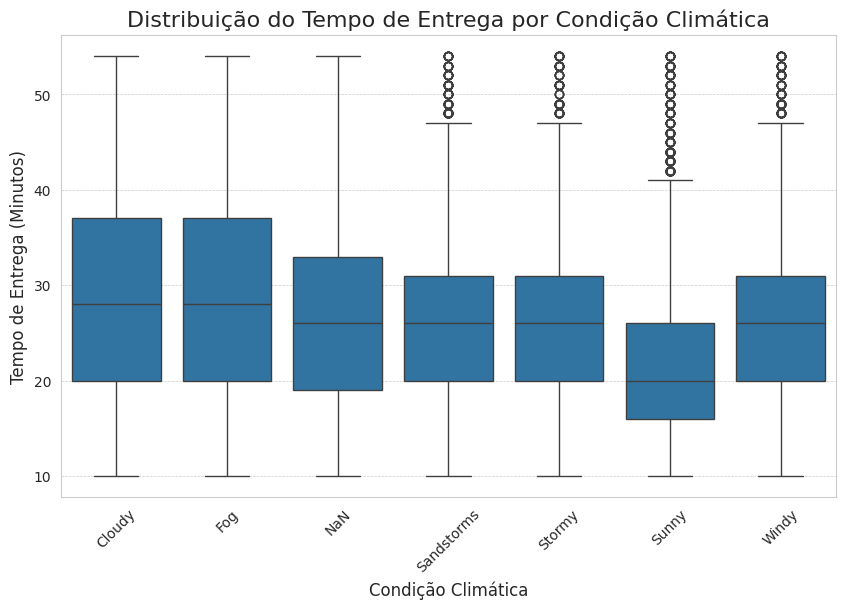

In [26]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_cleaned,
    x='WEATHERCONDITIONS',
    y='TIME_TAKEN_MIN'
)

plt.title('Distribuição do Tempo de Entrega por Condição Climática', fontsize=16)
plt.xlabel('Condição Climática', fontsize=12)
plt.ylabel('Tempo de Entrega (Minutos)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', linewidth=0.5)
plt.show()

##### Densidade do Tráfego vs. Hora do Pedido

> O heatmap apresenta para a densidade do tráfego um padrão cíclico diário claro, não havendo condições de trânsito que se sobrepõem. Dessa forma, tratar a feature de horário do pedido de forma cíclica acrescentará um contexto claro ao aprendizado dos modelos.

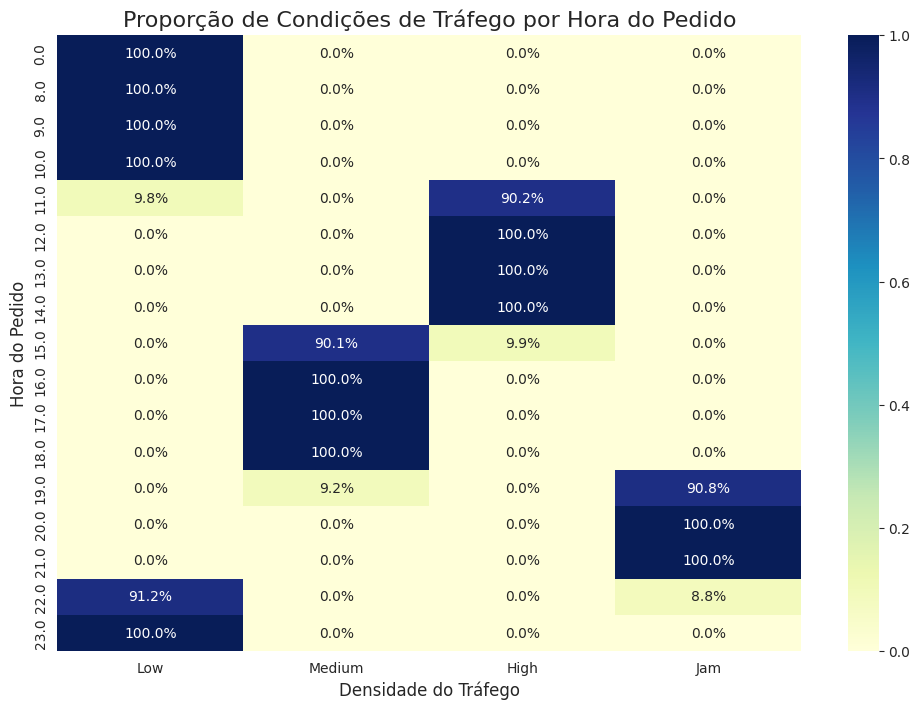

In [27]:
df_analysis = df_cleaned.copy()

# 1. Extrair a hora
df_analysis['HOUR_ORDERED'] = pd.to_timedelta(df_analysis['TIME_ORDERD'], errors='coerce').dt.seconds // 3600

# 2. Criar tabela de contingência com proporções
crosstab = pd.crosstab(
    df_analysis['HOUR_ORDERED'],
    df_analysis['ROAD_TRAFFIC_DENSITY'],
    normalize='index'
)

# 3. Ordenar as colunas de tráfego de forma lógica
traffic_order = ['Low', 'Medium', 'High', 'Jam']
crosstab = crosstab[traffic_order]

# 4. Gerar o heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    crosstab,
    annot=True,
    cmap='YlGnBu',
    fmt='.1%'
)

plt.title('Proporção de Condições de Tráfego por Hora do Pedido', fontsize=16)
plt.xlabel('Densidade do Tráfego', fontsize=12)
plt.ylabel('Hora do Pedido', fontsize=12)
plt.show()


##### Condição do Veículo vs. Tipo de Veículo

> O heatmap serve para investigar se a suposição de avaliar a condição do veículo em uma escala de qualidade (Excelente/Ruim) é válida ou não. A condição de todas as bicicletas serem definidas como `Ruim` alerta para um possível erro de interpretação, uma vez que é altamente improvável todas as bicicletas serem de baixa qualidade. Sendo assim, decido por não utilizar esta variável no aprendizado do modelo uma vez que não tenho confiança a cerca do seu real significado.

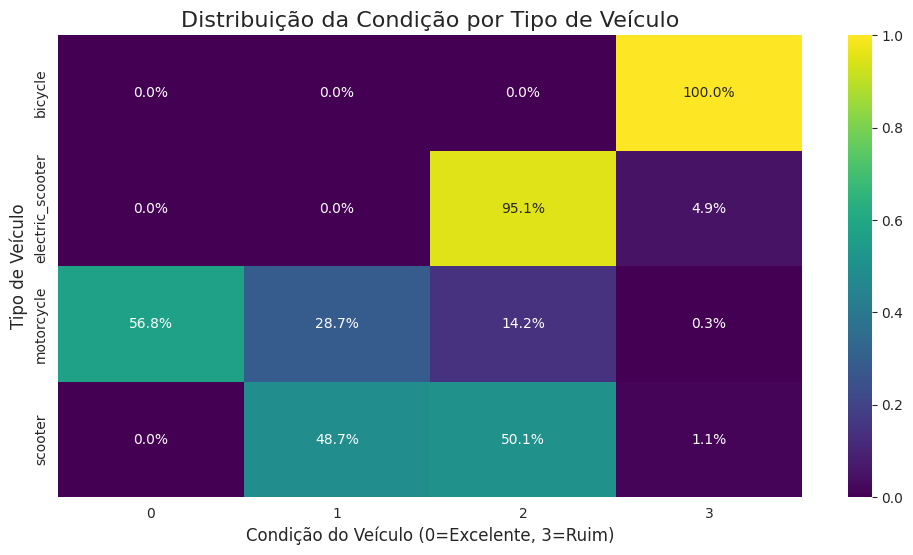

In [28]:
crosstab = pd.crosstab(df_cleaned['TYPE_OF_VEHICLE'],  df_cleaned['VEHICLE_CONDITION'], normalize='index')

plt.figure(figsize=(12, 6))
sns.heatmap(
    crosstab,
    annot=True,
    cmap='viridis',
    fmt='.1%')

plt.title('Distribuição da Condição por Tipo de Veículo', fontsize=16)
plt.xlabel('Condição do Veículo (0=Excelente, 3=Ruim)', fontsize=12)
plt.ylabel('Tipo de Veículo', fontsize=12)
plt.show()

##### Tipo de Veículo VS. Tempo de Entrega

> O boxplot contraria a ideia inicial de agrupar as categorias `eletric_scooter` e `bycicle` em uma mesma categoria devido a baixa representatividade. Na verdade, a visualização do boxplot indica que o agrupamento mais indicado é o dos valores de `eletric_scooter` e `scooter` em uma categoria de `scooters`.

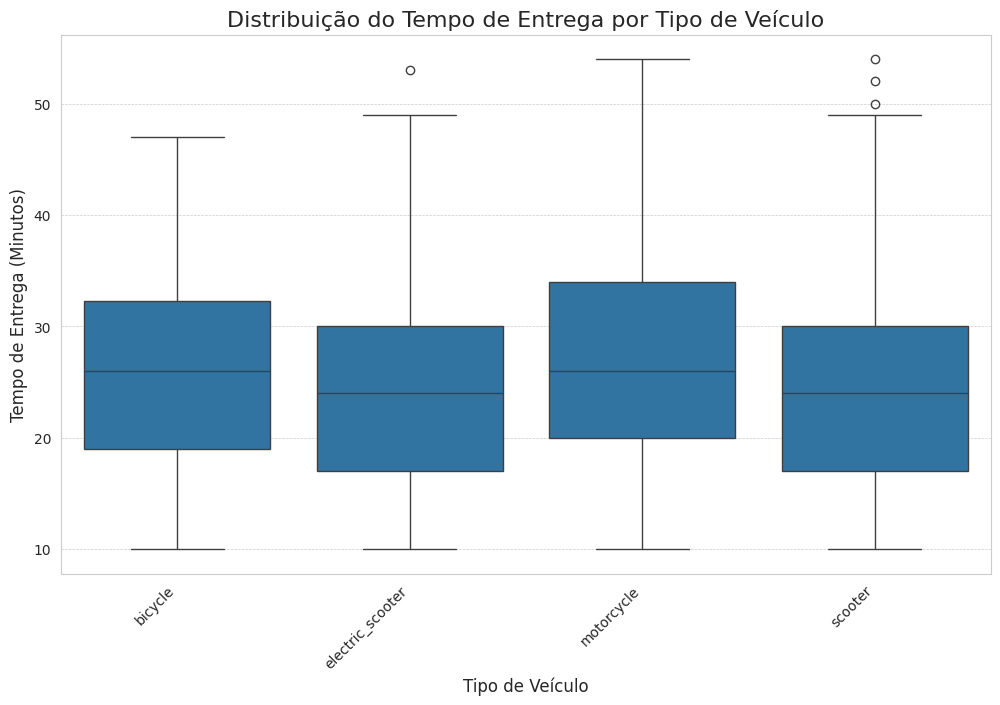

In [29]:
plt.figure(figsize=(12, 7))
sns.boxplot(
    data=df_cleaned,
    x='TYPE_OF_VEHICLE',
    y='TIME_TAKEN_MIN'
)

plt.title('Distribuição do Tempo de Entrega por Tipo de Veículo', fontsize=16)
plt.xlabel('Tipo de Veículo', fontsize=12)
plt.ylabel('Tempo de Entrega (Minutos)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', linestyle='--', linewidth=0.5)
plt.show()

---
# 5. Engenharia de Atributos

Com base nas avaliações resultantes da Análise Exploratória de Dados, esta etapa de Engenharia de Atributos visa utilizar o dataframe resultante da etapa de Limpeza de Dados para extrair informações implícitas no dataset inicial e melhorar o contexto das informações explícitas para aumentar o poder preditivo de cada uma das colunas. Nesta fase, percorrerei as etapas de:

1.  **Atributos Geográficos:** usando as colunas de latitude e longitude para calcular a distância real em quilômetros entre o restaurante e o local de entrega;
2.  **Atributos Temporais:** as colunas de data e hora serão utilizadas para extrair informações valiosas como o tempo de preparo, o dia da semana e a hora do pedido;
3.  **Atributos Cíclicos:** as colunas de hora do pedido e dia da semana serão transformadas utilizando funções de seno e cosseno. Esta técnica mapeia a natureza cíclida do tempo (onde 23h é adjacente a 0h) em um espaço contínuo, permitindo que o modelo compreenda corretamente esses padrões;
4.  **Atributos de Performance:** as colunas de avaliação e quantidade de pedidos serão combinadas para criar uma feature de "score de eficiência". Esta variável de interação visa capturar o conceito de performance do entregador sob diferentes cargas de trabalho;
5.  **Atributos com Agrupamentos de Categoria:** as colunas de tipo de veículo e condição climática serão otimizadas através do agrupamento estratégico de categorias visando reduzir a dimensionalidade e aumentar o poder preditivo.

In [30]:
df_engeneering = df_cleaned.copy()

### 5.1 - Atributos Geográficos

Conforme a hipótese levantada na Análise Exploratória, o valor preditivo das coordenadas geográficas reside na **distância** entre o restaurante e o local de entrega, e não em seus valores isolados. Para capturar esta informação, a feature `DISTANCE_KM` foi criada.

O cálculo foi realizado utilizando a **fórmula de Haversine**, que mede a distância entre dois pontos em uma esfera, levando em conta a curvatura da Terra.

Logo após a criação da feature, apresento uma amostra de registros da distância e do tempo de entrega e nela observo que, mesmo com potencial de alto poder preditivo, a relação entre as duas colunas não é linear.

In [31]:
def haversine_distance(lat1: pd.Series, lon1: pd.Series, lat2: pd.Series, lon2: pd.Series) -> pd.Series:
    """
    Calcula a distância Haversine entre dois pontos geográficos em quilômetros.

    Args:
        lat1 (pd.Series): Série pandas com as latitudes do ponto de origem.
        lon1 (pd.Series): Série pandas com as longitudes do ponto de origem.
        lat2 (pd.Series): Série pandas com as latitudes do ponto de destino.
        lon2 (pd.Series): Série pandas com as longitudes do ponto de destino.

    Returns:
        pd.Series: Uma série pandas contendo a distância em quilômetros para cada par de pontos.
    """
    # Raio da Terra em quilômetros
    R = 6371.0

    # Converte as coordenadas de graus para radianos
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    # Calcula as diferenças de longitude e latitude
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad

    # Aplica a fórmula de Haversine
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Calcula a distância final
    distance_km = R * c

    return distance_km

df_engeneering['DISTANCE_KM'] = haversine_distance(
    lat1=df_engeneering['RESTAURANT_LATITUDE'],
    lon1=df_engeneering['RESTAURANT_LONGITUDE'],
    lat2=df_engeneering['DELIVERY_LOCATION_LATITUDE'],
    lon2=df_engeneering['DELIVERY_LOCATION_LONGITUDE']
)

df_engeneering[['DISTANCE_KM', 'TIME_TAKEN_MIN']].sample(5).sort_values(by='TIME_TAKEN_MIN', ascending=False)

,DISTANCE_KM,TIME_TAKEN_MIN
7725,12.099555,44
949,13.681083,41
44893,14.021810,39
42071,17.074749,38
27091,10.564616,38


### 5.2 - Atributos Temporais

Com base nas colunas originais de data e hora, novas colunas foram obtidas a fim ampliar o contexto temporal através de variáveis que capturam os padrões cíclicos e de negócio da operação.

As seguintes features foram criadas e validadas:
* **`DATETIME_ORDERED` e `DATETIME_PICKED`:** colunas `datetime` que servem de base para os cálculos subsequentes;
* **`PREPARATION_TIME_MIN`:** métrica de negócio calculada como a diferença em minutos entre a coleta e a realização do pedido;
* **`ORDER_HOUR` e `DAY_OF_WEEK`:** features numéricas que extraem os componentes cíclicos diários e semanais dos pedidos;
* **`MEAL_TIME`:** uma feature categórica de negócio (`Lunch`, `Dinner`, `Off-Peak`) criada a partir da `ORDER_HOUR` para agrupar os pedidos em períodos operacionais distintos.

In [32]:
# 1. Combinar ORDER_DATE com as colunas de tempo para criar datetime completos
df_engeneering['DATETIME_ORDERED'] = df_engeneering['ORDER_DATE'] + df_engeneering['TIME_ORDERD']
df_engeneering['DATETIME_PICKED'] = df_engeneering['ORDER_DATE'] + df_engeneering['TIME_ORDER_PICKED']

# 2. Criar as novas colunas
df_engeneering['PREPARATION_TIME_MIN'] = (df_engeneering['DATETIME_PICKED'] - df_engeneering['DATETIME_ORDERED']).dt.total_seconds() / 60
df_engeneering['ORDER_HOUR'] = df_engeneering['DATETIME_ORDERED'].dt.hour
df_engeneering['DAY_OF_WEEK'] = df_engeneering['DATETIME_ORDERED'].dt.dayofweek # Segunda-feira=0

conditions = [
    df_engeneering['ORDER_HOUR'].between(11, 14), # Almoço
    df_engeneering['ORDER_HOUR'].between(18, 22)  # Jantar
]
choices = ['Lunch', 'Dinner']
df_engeneering['MEAL_TIME'] = np.select(conditions, choices, default='Off-Peak')
df_engeneering['MEAL_TIME'] = df_engeneering['MEAL_TIME'].astype('category')

# 3. Verificação dos resultados
cols_to_show = ['DATETIME_ORDERED',  'DATETIME_PICKED',  'PREPARATION_TIME_MIN',  'ORDER_HOUR',  'DAY_OF_WEEK', 'MEAL_TIME']
display(df_engeneering[cols_to_show].sample(5))

,DATETIME_ORDERED,DATETIME_PICKED,PREPARATION_TIME_MIN,ORDER_HOUR,DAY_OF_WEEK,MEAL_TIME
11664,2022-03-15 11:35:00,2022-03-15 11:50:00,15.0,11.0,1.0,Lunch
33177,2022-03-23 18:55:00,2022-03-23 19:00:00,5.0,18.0,2.0,Dinner
23239,NaT,2022-04-04 22:50:00,NaN,NaN,NaN,Off-Peak
19524,2022-03-12 21:20:00,2022-03-12 21:30:00,10.0,21.0,5.0,Dinner
14517,2022-03-16 17:30:00,2022-03-16 17:45:00,15.0,17.0,2.0,Off-Peak


### 5.3 - Atributos Cíclicos

Variáveis temporais como a hora do dia e o dia da semana possuem uma natureza cíclica (por exemplo, a hora 23 é tão próxima da hora 0 quanto da hora 22). Um modelo de machine learning, ao ver esses dados como números inteiros (`0, 1, 2...`), não consegue capturar essa proximidade.

Para resolver isso, esta subetapa aplica uma transformação de seno e cosseno às variáveis `ORDER_HOUR` e `DAY_OF_WEEK`. Esta técnica mapeia cada ponto do ciclo em um círculo, criando duas novas features (`_SIN` e `_COS`) que, juntas, informam ao modelo a posição exata no ciclo de forma contínua.

In [33]:
# 1. Transformação Cíclica para a hora do pedido (ciclo de 24 horas)
df_engeneering['HOUR_SIN'] = np.sin(2 * np.pi * df_engeneering['ORDER_HOUR'] / 24.0)
df_engeneering['HOUR_COS'] = np.cos(2 * np.pi * df_engeneering['ORDER_HOUR'] / 24.0)

# 2. Transformação Cíclica para o dia da semana (ciclo de 7 dias)
df_engeneering['DAY_SIN'] = np.sin(2 * np.pi * df_engeneering['DAY_OF_WEEK'] / 7.0)
df_engeneering['DAY_COS'] = np.cos(2 * np.pi * df_engeneering['DAY_OF_WEEK'] / 7.0)

# 3. Verificação dos resultados
print("Features cíclicas (sin/cos) para hora e dia da semana criadas com sucesso.")
cols_to_show = [
    'ORDER_HOUR', 'HOUR_SIN', 'HOUR_COS',
    'DAY_OF_WEEK', 'DAY_SIN', 'DAY_COS'
]
display(df_engeneering[cols_to_show].head())

Features cíclicas (sin/cos) para hora e dia da semana criadas com sucesso.


,ORDER_HOUR,HOUR_SIN,HOUR_COS,DAY_OF_WEEK,DAY_SIN,DAY_COS
0,11.0,0.258819,-9.659258e-01,5.0,-0.974928,-0.222521
1,19.0,-0.965926,2.588190e-01,4.0,-0.433884,-0.900969
2,8.0,0.866025,-5.000000e-01,5.0,-0.974928,-0.222521
3,18.0,-1.000000,-1.836970e-16,1.0,0.781831,0.623490
4,13.0,-0.258819,-9.659258e-01,5.0,-0.974928,-0.222521


### 5.4 - Atributos de Performance

Após a criação das features mais diretas, busquei o exercício de desenvolver um indicador que pudesse fornecer um contexto mais rico ao modelo. A ideia foi criar uma interpretação acerca da "eficiência sob pressão" a partir da interação de duas features que, na minha análise, representam os pilares da performance de um entregador: a sua qualidade (`DELIVERY_PERSON_RATINGS`) e a sua carga de trabalho (`MULTIPLE_DELIVERIES`).

O raciocínio por trás do desenvolvimento deste indicador foi um processo iterativo garantir que a feature final fosse matematicamente robusta e alinhada à intuição de negócio:

> 1.  **Hipótese Inicial:** a primeira ideia foi uma razão simples (`Avaliação / Qtd Entregas`), mas logo identifiquei que esta fórmula gerava cenários onde um entregador bom e ocupado poderia receber a mesma pontuação de um entregador ruim e ocioso, criando uma ambiguidade que seria prejudicial ao modelo;

> 2.  **Interação Multiplicativa:** a abordagem foi invertida para uma multiplicação (`Avaliação * Qtd Entregas`). Esta versão resolveu a ambiguidade, mas criou um problema de escala, onde a diferença de pontuação entre um bom entregador com mais de 1 entrega era muito maior do que a diferença entre um bom e um mau entregador com uma única entrega;

> 3.  **Valorização da Avaliação:** para garantir que a qualidade do serviço tivesse um peso maior na fórmula do que a carga de trabalho, optei por elevar a `Avaliação` ao quadrado. Esta transformação exponencial amplifica significativamente a diferença entre avaliações altas e baixas, alinhando a feature à premissa de negócio de que a qualidade do serviço é o fator mais crítico;

> 4.  **Ajuste Final de Escala:** para comprimir a escala da nova feature e garantir uma distribuição mais estável, apliquei a função de **logaritmo natural** sobre o resultado da interação já ponderada.

A combinação destes refinamentos resultou na seguinte fórmula final para o `EFFICIENCY_SCORE_LOG`:

$$
\text{Score Eficiência} = \ln((\text{Avaliação})^{2} \times (\text{Qtd Entregas Múltiplas} + 1))
$$


In [34]:
# 1. Definir a fórmula da feature: log(Ratings ao quadrado * Carga de Trabalho)
workload = df_engeneering['MULTIPLE_DELIVERIES'] + 1
ratings_squared = df_engeneering['DELIVERY_PERSON_RATINGS'] ** 2
df_engeneering['EFFICIENCY_SCORE_LOG'] = np.log(ratings_squared * workload)

# 2. Verificação dos resultados
print("Nova coluna de eficiência criada com sucesso. Amostra dos resultados:")
cols_to_show = [
    'DELIVERY_PERSON_RATINGS',
    'MULTIPLE_DELIVERIES',
    'EFFICIENCY_SCORE_LOG'
]

display(df_engeneering[cols_to_show].sample(10).sort_values(by='EFFICIENCY_SCORE_LOG', ascending=False))

Nova coluna de eficiência criada com sucesso. Amostra dos resultados:


,DELIVERY_PERSON_RATINGS,MULTIPLE_DELIVERIES,EFFICIENCY_SCORE_LOG
2889,4.9,1,3.871618
17676,4.8,1,3.830379
25768,4.7,1,3.788272
6561,4.7,1,3.788272
44356,4.7,1,3.788272
14437,4.0,1,3.465736
37646,4.9,0,3.17847
6296,4.8,0,3.137232
40332,3.8,0,2.670002
8089,NaN,0,<NA>


### 5.5 - Atributos com Agrupamentos de Categoria

O objetivo é realizar a redução de dimensionalidade através do agrupamento de categorias com base nas evidências da análise bivariada. Esta prática cria grupos mais representativos e com maior poder estatístico.

As seguintes transformações foram realizadas:

* **`TYPE_OF_VEHICLE`:** a análise dos boxplots mostrou que as categorias `'scooter'` e `'electric_scooter'` possuem distribuições de tempo de entrega muito similares. Com base nisso, foram consolidadas em uma única categoria, `'scooters'`, para simplificar a variável;
* **`WEATHERCONDITIONS`:** a análise quantitativa revelou que os pares de categorias `'Cloudy'` e `'Fog'`, bem como `'Sandstorms'` e `'Stormy'`, tinham um impacto estatístico praticamente idêntico no tempo de entrega. Para fortalecer o sinal preditivo, foram realizados os seguintes agrupamentos:
    * `'Cloudy'` e `'Fog'` foram agrupados em `'Cloudy/Fog'`.
    * `'Sandstorms'` e `'Stormy'` foram agrupados em `'Adverse'`.

In [35]:
mapping = {
    'TYPE_OF_VEHICLE': {
        'scooter': 'scooters',
        'electric_scooter': 'scooters'
    },
    'WEATHERCONDITIONS': {
        'Sandstorms': 'Adverse',
        'Stormy': 'Adverse',
        'Cloudy': 'Cloudy/Fog',
        'Fog': 'Cloudy/Fog'
    }
}

for col, value_map in mapping.items():
    df_engeneering[col] = df_engeneering[col].replace(value_map)
    df_engeneering[col] = df_engeneering[col].astype('category')

print("\n--- Novas Categorias em 'TYPE_OF_VEHICLE' ---")
display(df_engeneering['TYPE_OF_VEHICLE'].value_counts())

print("\n--- Novas Categorias em 'WEATHERCONDITIONS' ---")
display(df_engeneering['WEATHERCONDITIONS'].value_counts())


--- Novas Categorias em 'TYPE_OF_VEHICLE' ---


/tmp/ipython-input-965887250.py:15: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_engeneering[col] = df_engeneering[col].replace(value_map)


,count
TYPE_OF_VEHICLE,
motorcycle,26435
scooters,19090
bicycle,68



--- Novas Categorias em 'WEATHERCONDITIONS' ---


,count
WEATHERCONDITIONS,
Cloudy/Fog,15190
Adverse,15081
Windy,7422
Sunny,7284
NaN,616


### 5.6 - Definição do Dataset Final para Modelagem

Com base em todas as análises e transformações realizadas, esta célula seleciona o conjunto definitivo de variáveis que serão utilizadas para treinar o modelo de machine learning.

Foram removidas todas as colunas brutas que foram substituídas por features de engenharia (como as coordenadas e as colunas de data/hora originais), além de variáveis cujo significado se mostrou ambíguo (`VEHICLE_CONDITION`).

In [36]:
final_columns = [
    'DELIVERY_PERSON_ID',
    'DELIVERY_PERSON_AGE',
    'DELIVERY_PERSON_RATINGS',
    'WEATHERCONDITIONS',
    'ROAD_TRAFFIC_DENSITY',
    'TYPE_OF_ORDER',
    'TYPE_OF_VEHICLE',
    'MULTIPLE_DELIVERIES',
    'FESTIVAL',
    'CITY',
    'DISTANCE_KM',
    'PREPARATION_TIME_MIN',
    'MEAL_TIME',
    'HOUR_SIN',
    'HOUR_COS',
    'DAY_SIN',
    'DAY_COS',
    'EFFICIENCY_SCORE_LOG',
    'TIME_TAKEN_MIN'
]

df_model = df_engeneering[final_columns].copy()
df_model.sample(5)
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   DELIVERY_PERSON_ID       45593 non-null  string  
 1   DELIVERY_PERSON_AGE      43739 non-null  Int8    
 2   DELIVERY_PERSON_RATINGS  43685 non-null  float32 
 3   WEATHERCONDITIONS        45593 non-null  category
 4   ROAD_TRAFFIC_DENSITY     44992 non-null  category
 5   TYPE_OF_ORDER            45593 non-null  category
 6   TYPE_OF_VEHICLE          45593 non-null  category
 7   MULTIPLE_DELIVERIES      44600 non-null  Int8    
 8   FESTIVAL                 45365 non-null  category
 9   CITY                     44393 non-null  category
 10  DISTANCE_KM              45593 non-null  float32 
 11  PREPARATION_TIME_MIN     43862 non-null  float64 
 12  MEAL_TIME                45593 non-null  category
 13  HOUR_SIN                 43862 non-null  float64 
 14  HOUR_C

---
# 6 - Pré-processamento e Modelagem

### 6.1 - Configuração e Definição das Variáveis de Modelagem

Esta etapa é dedicada à configuração do ambiente e à preparação das estruturas de dados que serão utilizadas no treinamento e validação.

As seguintes ações foram executadas:
> 1.  **Centralização de Parâmetros (`CONFIG`):** foi definido um dicionário `CONFIG` para armazenar todas as constantes do projeto, como a `seed` para aleatoriedade, listas de features numéricas e categóricas, e nomes de colunas chave;

> 2.  **Separação de Variáveis:** o dataset final foi segmentado em três componentes essenciais:
    * **`X`**: a matriz contendo exclusivamente as features preditivas;
    * **`y`**: o vetor contendo a variável alvo (`TIME_TAKEN_MIN`);
    * **`groups`**: uma série contendo o identificador do entregador (`DELIVERY_PERSON_ID`), que será utilizada nas etapas subsequentes para garantir uma validação cruzada que previna o *data leakage*;

> 3.  **Garantia de Integridade:** foram adicionadas verificações para confirmar que as variáveis `y` e `groups` não contêm valores nulos;

> 4.  **Definição da Transformação do Alvo:** foi definida a tupla `target_transformer_funcs` que será utilizada pelo `TransformedTargetRegressor`. Com base na baixa assimetria da variável alvo, identificada na análise exploratória, utilizou-se uma função identidade para manter a consistência da arquitetura do modelo.


In [37]:
# 1. Dicionário de configuração que será usada ao longo da etapa de pré-processamento e modelagem
CONFIG = {
    "seed": SEED,
    "artifacts_path": "artifacts",
    "target_col": "TIME_TAKEN_MIN",
    "group_col": "DELIVERY_PERSON_ID",
    "feature_cols": {
        "numeric": [
            'DELIVERY_PERSON_AGE', 'DELIVERY_PERSON_RATINGS', 'MULTIPLE_DELIVERIES',
            'DISTANCE_KM', 'PREPARATION_TIME_MIN', 'EFFICIENCY_SCORE_LOG',
            'HOUR_SIN', 'HOUR_COS', 'DAY_SIN', 'DAY_COS'
        ],
        "categorical": [
            'WEATHERCONDITIONS', 'ROAD_TRAFFIC_DENSITY',
            'TYPE_OF_ORDER', 'TYPE_OF_VEHICLE', 'FESTIVAL', 'CITY', 'MEAL_TIME'
        ]
    },
    "test_size_ratio": 0.2,
}

# 2. Definição de X (features), y (alvo) e groups (para divisão)
features_to_use = CONFIG["feature_cols"]["numeric"] + CONFIG["feature_cols"]["categorical"]
X = df_model[features_to_use]
y = df_model[CONFIG["target_col"]].astype(float)
groups = df_model[CONFIG["group_col"]]

# 3. Verificação de Sanidade
assert y.isnull().sum() == 0, "A variável alvo 'y' contém valores nulos."
assert groups.isnull().sum() == 0, "A variável de grupo 'groups' contém valores nulos."
print("Verificação de sanidade (ausência de nulos em 'y' e 'groups') passou com sucesso.")

# 4. Função identidade que retorna a entrada sem modificação.
def identity_func(x):
    return x

target_transformer_funcs = (identity_func, identity_func)

# 5. Verificação final dos shapes
print(f"\nShape de X: {X.shape}")
print(f"Shape de y: {y.shape}")
print(f"Shape de groups: {groups.shape}")

Verificação de sanidade (ausência de nulos em 'y' e 'groups') passou com sucesso.

Shape de X: (45593, 17)
Shape de y: (45593,)
Shape de groups: (45593,)


### 6.2 - Divisão Agrupada dos Dados (Treino e Teste)

Nesta etapa, os dados foram divididos em conjuntos de treino e teste. Para garantir que o aprendizado do modelo seja livre de *data leakage*, foi utilizada a estratégia `GroupShuffleSplit`. Este método assegura que todas as entregas associadas a um mesmo `DELIVERY_PERSON_ID` sejam mantidas inteiramente em um único conjunto (ou treino, ou teste).

Como garantia final da integridade do processo, verificações a cerca do tamanho, da intersecção de entregadores e da representatividade da variável alvo entre os conjuntos foi executada para confirmar a validade do processo.

In [38]:
# 1. Instancia o divisor de grupos
gss = GroupShuffleSplit(n_splits=1, test_size=CONFIG["test_size_ratio"], random_state=CONFIG["seed"])

# 2. Gera os índices e cria os dataframes
train_idx, test_idx = next(gss.split(X, y, groups=groups))
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
groups_train = groups.iloc[train_idx]
groups_test = groups.iloc[test_idx]

# 3. Verificações da divisão dos dados
print("--- Divisão de Dados e Verificação Anti-Leakage ---")
print(f"Shape de X_train: {X_train.shape}")
print(f"Shape de y_train: {y_train.shape}")
print(f"Shape de X_test: {X_test.shape}")
print(f"Shape de y_test: {y_test.shape}")

# 4. Verificação Anti-Leakage
train_deliverers = set(groups_train.unique())
test_deliverers = set(groups_test.unique())
leakage = train_deliverers.intersection(test_deliverers)
assert len(leakage) == 0, "FALHA CRÍTICA: Detectado vazamento de grupos entre treino e teste."
print(f"\n✅ Verificação Anti-Leakage: OK (Interseção de entregadores = {len(leakage)})")

# 5. Diagnósticos de representatividade
m_tr, s_tr = float(y_train.mean()), float(y_train.std(ddof=1))
m_te, s_te = float(y_test.mean()),  float(y_test.std(ddof=1))
mean_rel_diff = abs(m_tr - m_te) / abs(m_tr) if m_tr != 0 else 0.0
std_rel_diff  = abs(s_tr - s_te) / (abs(s_tr) + 1e-12) if s_tr != 0 else 0.0

print("\n--- Diagnósticos de Representatividade ---")
print(f"Proporção de linhas no teste: {len(X_test) / len(X):.2%}")
print(f"Proporção de grupos no teste: {len(test_deliverers) / groups.nunique():.2%}")
print(f"Diferença relativa na média do alvo: {mean_rel_diff:.2%}")
print(f"Diferença relativa no desvio padrão do alvo: {std_rel_diff:.2%}")

--- Divisão de Dados e Verificação Anti-Leakage ---
Shape de X_train: (36612, 17)
Shape de y_train: (36612,)
Shape de X_test: (8981, 17)
Shape de y_test: (8981,)

✅ Verificação Anti-Leakage: OK (Interseção de entregadores = 0)

--- Diagnósticos de Representatividade ---
Proporção de linhas no teste: 19.70%
Proporção de grupos no teste: 20.00%
Diferença relativa na média do alvo: 0.50%
Diferença relativa no desvio padrão do alvo: 0.42%


### 6.3 - Construção do Pipeline de Pré-processamento

Nesta etapa, é construído o pipeline de pré-processamento para garantir que as mesmas transformações sejam aplicadas de forma consistente tanto nos dados de treino quanto nos de teste.

A construção foi dividida em três pipelines especializados, orquestrados por um `ColumnTransformer`:

1.  **Pipeline Numérico:**
    * **Imputação:** valores ausentes são preenchidos com a mediana da coluna.
    * **Escalonamento:** as features são padronizadas com `StandardScaler`.

2.  **Pipeline Categórico Ordinal:**
    * **Variável Alvo:** Aplicado exclusivamente à feature `ROAD_TRAFFIC_DENSITY`, que possui uma ordem intrínseca ('Low' < 'Medium' < 'High' < 'Jam').
    * **Imputação:** Valores ausentes são preenchidos com a moda.
    * **Encoding:** Utiliza `OrdinalEncoder` para converter as categorias em valores numéricos que preservam a relação de ordem.

3.  **Pipeline Categórico Nominal:**
    * **Variáveis Alvo:** aplicado às demais features categóricas que não possuem uma relação de ordem.
    * **Imputação:** valores ausentes são preenchidos com a moda.
    * **Encoding:** utiliza-se o `OneHotEncoder` para transformar cada categoria em uma nova coluna binária.

In [39]:
# 1 Definição dos grupos de feature
numeric_features = CONFIG['feature_cols']['numeric']
ordinal_feature = ['ROAD_TRAFFIC_DENSITY']
nominal_features = [col for col in CONFIG['feature_cols']['categorical'] if col not in ordinal_feature]

# 2. Pipeline para features numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 3. Pipeline para a feature categórica ordinal
traffic_order = ['Low', 'Medium', 'High', 'Jam']
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(categories=[traffic_order]))
])

# 4. Pipeline para features categóricas nominais
nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', min_frequency=0.01, sparse_output=False, dtype=np.float32))
])

# 5. Montagem do pré-processador com ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('ord', ordinal_transformer, ordinal_feature),
    ('nom', nominal_transformer, nominal_features)
], remainder='drop', n_jobs=None)

# 6. Extração e persistência dos nomes finais das features
preprocessor.fit(X_train, y_train)
final_feature_names = preprocessor.get_feature_names_out().tolist()
os.makedirs(CONFIG["artifacts_path"], exist_ok=True)
features_path = os.path.join(CONFIG["artifacts_path"], "final_feature_names.json")
with open(features_path, "w", encoding="utf-8") as f:
    json.dump(final_feature_names, f, ensure_ascii=False, indent=4)

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['DELIVERY_PERSON_AGE',
                                  'DELIVERY_PERSON_RATINGS',
                                  'MULTIPLE_DELIVERIES', 'DISTANCE_KM',
                                  'PREPARATION_TIME_MIN',
                                  'EFFICIENCY_SCORE_LOG', 'HOUR_SIN',
                                  'HOUR_COS', 'DAY_SIN', 'DAY_COS']),
                                ('ord',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImput...
                                                  OrdinalEncoder(categories=[['Low',
                                                                              'Medium',
                                                                              'High',
                                                                              'Jam']]))]),
                                 ['ROAD_TRAFFIC_DENSITY']),
                                ('nom',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(dtype=<class 'numpy.float32'>,
                                                                handle_unknown='ignore',
                                                                min_frequency=0.01,
                                                                sparse_output=False))]),
                                 ['WEATHERCONDITIONS', 'TYPE_OF_ORDER',
                                  'TYPE_OF_VEHICLE', 'FESTIVAL', 'CITY',
                                  'MEAL_TIME'])])

### 6.4 - Comparação de Modelos

Nesta etapa, é executada uma competição .

Nesta etapa realizo uma competição entre diferentes algoritmos para identificar, através da validação cruzada, o apresenta melhor performance nos dados de treino. As principais ações executadas são:

> 1.  **Estratégia de Validação:** utilizo `GroupKFold` com 5 splits, para garantir que todas as entregas de um mesmo entregador (`DELIVERY_PERSON_ID`) sejam mantidas no mesmo conjunto prevenindo o data leakage;

> 2.  **Métricas de Avaliação:** utilizo três métricas para avaliar o desempenho de cada modelo: **MAE** (focado no erro médio em minutos), **RMSE** (penaliza erros maiores com mais intensidade) e **R²** (mede o quão bem o modelo explica a variabilidade dos dados);

> 3.  **Modelos Candidatos:** `DummyRegressor` (baseline que prevê a média), modelos lineares (`Ridge`, `Lasso`, `ElasticNet`) e modelos baseados em arvore (`RandomForestRegressor`, `LGBMRegressor`, `CatBoostRegressor`);

> 4.  **Execução e Resultados:** cada modelo é combinado com o pipeline de pré-processamento da etapa anterior e avaliado através do `cross_validate`.

In [40]:
def run_model_comparison(X_train, y_train, groups_train, preprocessor, CONFIG):
    """
    Executa o processo completo de comparação de modelos, incluindo a definição
    da estratégia de validação, a avaliação dos candidatos e a persistência
    dos resultados em arquivos de artefatos.

    Args:
        X_train (pd.DataFrame): DataFrame de features de treino.
        y_train (pd.Series): Series com a variável alvo de treino.
        groups_train (pd.Series): Series com os grupos para a validação cruzada.
        preprocessor (ColumnTransformer): O pipeline de pré-processamento já treinado.
        CONFIG (dict): Dicionário de configuração do projeto.

    Returns:
        pd.DataFrame: DataFrame com o resumo dos resultados da comparação.
    """

    print("Iniciando a validação cruzada para os modelos candidatos (Modo Completo)...")

    # 1. Definição da validação cruzada
    cv_splits = CONFIG.get("cv_splits", 5)
    cv_strategy = GroupKFold(n_splits=cv_splits)

    # 2. Definição das métricas de avaliação
    def rmse(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))

    scorers = {
        "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
        "RMSE": make_scorer(rmse, greater_is_better=False),
        "R2": "r2"
    }

    # 3. Lista de modelos candidatos com parametrização dinâmica do pipeline
    candidates = [
        ("Baseline (Média)", DummyRegressor(strategy="mean"), {'preprocessor__num__scaler': 'passthrough'}),
        ("Linear (Ridge)", Ridge(random_state=CONFIG["seed"]), {}),
        ("Linear (Lasso)", Lasso(random_state=CONFIG["seed"]), {}),
        ("Linear (ElasticNet)", ElasticNet(random_state=CONFIG["seed"]), {}),
        ("RandomForest", RandomForestRegressor(random_state=CONFIG["seed"], n_jobs=-1), {'preprocessor__num__scaler': 'passthrough'}),
        ("LightGBM", LGBMRegressor(random_state=CONFIG["seed"], n_jobs=-1), {'preprocessor__num__scaler': 'passthrough'}),
        ("CatBoost", CatBoostRegressor(random_state=CONFIG["seed"], verbose=0), {'preprocessor__num__scaler': 'passthrough'})
    ]

    # 4. Execução da validação cruzada
    results_summary = []
    all_cv_results = {}

    for name, model, params in tqdm(candidates, desc="Avaliando Modelos"):
        final_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

        if params:
            final_pipeline.set_params(**params)

        cv_results = cross_validate(
            estimator=final_pipeline, X=X_train, y=y_train, groups=groups_train,
            scoring=scorers, cv=cv_strategy, n_jobs=-1, return_train_score=False)

        all_cv_results[name] = cv_results
        results_summary.append({
            "Modelo": name,
            "MAE_Média": -np.mean(cv_results['test_MAE']),
            "MAE_DesvioPadrão": np.std(cv_results['test_MAE']),
            "RMSE_Média": -np.mean(cv_results['test_RMSE']),
            "R2_Média": np.mean(cv_results['test_R2'])
        })

    # 5. Consolidação e persistência dos resultados
    summary_df = pd.DataFrame(results_summary).sort_values(by="MAE_Média").reset_index(drop=True)
    summary_path = os.path.join(CONFIG['artifacts_path'], "model_comparison_summary.csv")
    summary_df.to_csv(summary_path, index=False)

    per_fold_rows = []
    for name, cv_res in all_cv_results.items():
        for i in range(cv_splits):
            per_fold_rows.append({
                "Modelo": name, "Fold": i + 1,
                "MAE": -cv_res['test_MAE'][i], "RMSE": -cv_res['test_RMSE'][i], "R2": cv_res['test_R2'][i]
            })
    per_fold_df = pd.DataFrame(per_fold_rows)
    per_fold_path = os.path.join(CONFIG['artifacts_path'], "model_comparison_per_fold.csv")
    per_fold_df.to_csv(per_fold_path, index=False)

    print(f"\nResultados salvos em '{summary_path}' e '{per_fold_path}'.")

    return summary_df

In [41]:
if EXECUTAR_MODELAGEM_COMPLETA:
    # MODO COMPLETO: Executa a função e gera os artefatos
    summary_df = run_model_comparison(X_train, y_train, groups_train, preprocessor, CONFIG)
else:
    # MODO RÁPIDO: Carrega os resultados diretamente do repositório GitHub
    github_raw_url = "https://raw.githubusercontent.com/andregarofalovaz/pos-grad-datascience/refs/heads/main/artifacts/model_comparison_summary.csv"

    try:
        summary_df = pd.read_csv(github_raw_url)
    except Exception as e:
        print(f"ERRO: Não foi possível carregar o arquivo do GitHub. Detalhes: {e}")
        summary_df = pd.DataFrame()

print("\n--- Tabela de Classificação dos Modelos (Resumo) ---")
display(summary_df)


--- Tabela de Classificação dos Modelos (Resumo) ---


,Modelo,MAE_Média,MAE_DesvioPadrão,RMSE_Média,R2_Média
0,LightGBM,3.481932,0.035796,4.438212,0.775838
1,CatBoost,3.491488,0.035007,4.454994,0.774142
2,RandomForest,3.581850,0.031708,4.607357,0.758429
3,Linear (Ridge),5.025545,0.030941,6.382586,0.536409
4,Linear (ElasticNet),6.196830,0.049181,7.754130,0.315873
5,Linear (Lasso),6.284362,0.048294,7.853696,0.298190
6,Baseline (Média),7.586391,0.055506,9.376258,-0.000299


### 6.5 - Otimização de Hiperparâmetros

Após identificar o `LightGBM` como o modelo mais promissor, busco nesta etapa encontrar a combinação de hiperparâmetros que maximize sua performance preditiva. Para isso, utilizo a biblioteca `Optuna` para explorar o espaço de busca de forma eficiente. O processo é estruturado da seguinte forma:

> 1.  **Função Objetivo:** uma função é definida para receber um conjunto de hiperparâmetros sugeridos pelo Optuna, treina o modelo `LightGBM` utilizando a mesma estratégia de validação cruzada agrupada (`GroupKFold`) e retorna o MAE médio;

> 2.  **Estudo de Otimização:** é realizada uma avaliação atrav[es da execução da função objetivo por um número pré-definido de iterações;

> 3.  **Persistência dos Artefatos:** ao final da otimização, todos os o histórico das iterações e os melhores hiperparâmetros são salvos.

In [42]:
def run_hyperparameter_optimization(X_train, y_train, groups_train, preprocessor, CONFIG, n_trials=10):
    """
    Executa o processo completo de otimização de hiperparâmetros com Optuna,
    incluindo a definição da função objetivo, a execução do estudo e a
    persistência de todos os artefatos gerados.

    Args:
        X_train (pd.DataFrame): DataFrame de features de treino.
        y_train (pd.Series): Series com a variável alvo de treino.
        groups_train (pd.Series): Series com os grupos para a validação cruzada.
        preprocessor (ColumnTransformer): O pipeline de pré-processamento já treinado.
        CONFIG (dict): Dicionário de configuração do projeto.
        n_trials (int): O número de iterações que o Optuna deve executar.

    Returns:
        dict: Dicionário contendo os melhores hiperparâmetros encontrados.
    """

    print(f"Iniciando a otimização de hiperparâmetros para {n_trials} iterações (Modo Completo)...")

    # 1. Definição da função objetivo
    def objective(trial):
        cv_strategy = GroupKFold(n_splits=CONFIG.get("cv_splits", 5))

        params = {
            'n_estimators': trial.suggest_int('n_estimators', 400, 1500),
            'learning_rate': trial.suggest_float('learning_rate', 0.008, 0.03, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 30, 90),
            'max_depth': trial.suggest_int('max_depth', 8, 16),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 40),
            'subsample': trial.suggest_float('subsample', 0.7, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 0.2),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.4, 2.0),
            'random_state': CONFIG["seed"],
            'n_jobs': -1,
            'verbosity': -1
        }

        if params['max_depth'] != -1:
            params['num_leaves'] = min(params['num_leaves'], 2 ** params['max_depth'])

        model_to_tune = LGBMRegressor(**params)

        final_pipeline = Pipeline(
            steps=[('preprocessor', preprocessor), ('model', model_to_tune)]
        )
        final_pipeline.set_params(preprocessor__num__scaler='passthrough')

        scores = cross_val_score(
            final_pipeline, X_train, y_train, scoring='neg_mean_absolute_error',
            cv=cv_strategy, groups=groups_train, n_jobs=-1
        )

        return -np.mean(scores)

    optuna.logging.set_verbosity(optuna.logging.INFO)

    # 2. Execução do estudo de otimização
    study = optuna.create_study(
        direction='minimize',
        sampler=optuna.samplers.TPESampler(seed=CONFIG["seed"])
    )

    with tqdm(total=n_trials, desc="Otimizando com Optuna") as pbar:
        def callback(study, trial):
            pbar.update(1)
        study.optimize(objective, n_trials=n_trials, callbacks=[callback])

    # 3. Resultados
    best_params_from_study = study.best_params
    print(f"""
--- Resultados da Otimização ---
Melhor MAE na Validação Cruzada: {study.best_value:.4f} minutos

Melhores Hiperparâmetros Encontrados:
{best_params_from_study}""")

    # 4. Salvar os melhores parâmetros
    optuna_results = { "best_value_mae": float(study.best_value), "best_params": best_params_from_study }
    results_path = os.path.join(CONFIG["artifacts_path"], "optuna_best_params.json")
    with open(results_path, "w", encoding="utf-8") as f:
        json.dump(optuna_results, f, ensure_ascii=False, indent=4)
    print(f"\nArtefato com melhores parâmetros salvo em: {results_path}")

    # 5. Salvar o histórico de iterações
    trials_df = study.trials_dataframe(attrs=("number", "value", "params", "state"))
    trials_path = os.path.join(CONFIG["artifacts_path"], "optuna_trials.csv")
    trials_df.to_csv(trials_path, index=False)
    print(f"Histórico de trials salvo em: {trials_path}")

    # 6. Salvar metadados do estudo
    study_meta = {
        "cv_splits": int(CONFIG.get("cv_splits", 5)), "n_trials": int(n_trials), "seed": int(CONFIG["seed"]),
        "versions": {"sklearn": sklearn.__version__, "lightgbm": lgb.__version__}
    }
    meta_path = os.path.join(CONFIG["artifacts_path"], "optuna_study_meta.json")
    with open(meta_path, "w", encoding="utf-8") as f:
        json.dump(study_meta, f, ensure_ascii=False, indent=4)
    print(f"Metadados do estudo salvos em: {meta_path}")

    return best_params_from_study

In [43]:
if EXECUTAR_MODELAGEM_COMPLETA:
    # MODO COMPLETO: Executa a otimização e gera os artefatos
    best_params = run_hyperparameter_optimization(X_train, y_train, groups_train, preprocessor, CONFIG, n_trials=100)

    optuna_path = os.path.join(CONFIG["artifacts_path"], "optuna_best_params.json")
    with open(optuna_path, "r", encoding="utf-8") as f:
        mae_cv_best = json.load(f)["best_value_mae"]

else:
    # MODO RÁPIDO: Carrega os resultados diretamente do repositório GitHub
    print("Executando em modo rápido: carregando melhores hiperparâmetros pré-calculados.")
    github_raw_url = "https://raw.githubusercontent.com/andregarofalovaz/pos-grad-datascience/refs/heads/main/artifacts/optuna_best_params.json"

    try:
        response = requests.get(github_raw_url)
        response.raise_for_status()
        optuna_results = json.loads(response.text)
        best_params = optuna_results["best_params"]
        mae_cv_best = optuna_results["best_value_mae"]
        print("Hiperparâmetros e MAE da CV carregados com sucesso do GitHub.")
    except Exception as e:
        print(f"ERRO: Não foi possível carregar o arquivo do GitHub. Detalhes: {e}")
        best_params = {}

print("\nMelhores Hiperparâmetros a serem usados no treinamento final:")
print(best_params)

Executando em modo rápido: carregando melhores hiperparâmetros pré-calculados.
Hiperparâmetros e MAE da CV carregados com sucesso do GitHub.

Melhores Hiperparâmetros a serem usados no treinamento final:
{'n_estimators': 744, 'learning_rate': 0.009704229644191617, 'num_leaves': 81, 'max_depth': 13, 'min_child_samples': 30, 'subsample': 0.8298281316536745, 'colsample_bytree': 0.869152082042293, 'reg_alpha': 0.1913563935487522, 'reg_lambda': 1.2183011632135943}


### 6.6 - Treinamento do Modelo Final

É etapa final de modelagem, onde o modelo com melhor performance é treinado com sua melhor configuração de hiperparâmetros em todo o conjunto de dados de treino. As ações executadas são:

> 1.  **Carregamento dos Hiperparâmetros:** os melhores hiperparâmetros são carregados a partir do arquivo `optuna_best_params.json`;

> 2.  **Construção do Pipeline Final:** o `LGBMRegressor` é instanciado com os parâmetros otimizados e combinado com o pipeline de pré-processamento (`preprocessor`);

> 3.  **Treinamento:** o pipeline final é treinado utilizando todo os dados de treino;

> 4.  **Persistência dos Artefatos:** três arquivos são salvos para garantir que o modelo seja reproduzível a partir deste ponto, sendo:
>     * O modelo treinado (`final_model.joblib`);
>     * O relatório de treinamento (`training_report.json`);
>     * A configuração utilizada (`config.json`).

In [44]:
# 1. Carregar os melhores hiperparâmetros
assert best_params, "A variável 'best_params' está vazia. Verifique se a etapa 6.5 foi executada corretamente."
print("Melhores hiperparâmetros recebidos da etapa anterior com sucesso.")

# 2. Construir o pipeline final de forma simplificada
final_model_lgbm = LGBMRegressor(random_state=CONFIG["seed"], n_jobs=-1, verbosity=-1, **best_params)
final_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', final_model_lgbm)])
final_pipeline.set_params(preprocessor__num__scaler='passthrough')

# 3. Treinar o modelo final e medir o tempo de execução
print("\nIniciando o treinamento do modelo final com o conjunto de treino completo...")
tic = time.perf_counter()
final_pipeline.fit(X_train, y_train)
toc = time.perf_counter()
fit_time = toc - tic
print(f"Treinamento finalizado em {fit_time:.3f} segundos.")

# 4. Persistir os artefatos finais
# a) O modelo treinado
model_path = os.path.join(CONFIG["artifacts_path"], "final_model.joblib")
joblib.dump(final_pipeline, model_path, compress=3)
print(f"\nModelo final salvo com sucesso em: {model_path}")

# b) Relatório de treinamento
train_report = {
    "train_rows": int(len(X_train)),
    "train_groups": int(groups_train.nunique()),
    "fit_time_seconds": round(fit_time, 3),
    "final_hyperparameters": best_params,
    "library_versions": {"sklearn": sklearn.__version__, "lightgbm": lgb.__version__}
}
report_path = os.path.join(CONFIG["artifacts_path"], "training_report.json")
with open(report_path, "w", encoding="utf-8") as f:
    json.dump(train_report, f, ensure_ascii=False, indent=4)
print(f"Relatório de treinamento salvo em: {report_path}")

# c) A configuração final
config_path = os.path.join(CONFIG["artifacts_path"], "config.json")
with open(config_path, "w", encoding="utf-8") as f:
    json.dump(CONFIG, f, ensure_ascii=False, indent=4)
print(f"Configuração final do experimento salva em: {config_path}")

Melhores hiperparâmetros recebidos da etapa anterior com sucesso.

Iniciando o treinamento do modelo final com o conjunto de treino completo...
Treinamento finalizado em 4.588 segundos.

Modelo final salvo com sucesso em: artifacts/final_model.joblib
Relatório de treinamento salvo em: artifacts/training_report.json
Configuração final do experimento salva em: artifacts/config.json


---
# 7 - Interpretação dos Resultados

### 7.1. Avaliação Final e Validação da Generalização

Esta etapa avalia o modelo treinado no conjunto de dados de teste. O objetivo é quantificar a performance final do modelo e validar sua capacidade de generalização. As seguintes ações são executadas:

> 1.  **Carregamento do Modelo:** através do artefato `final_model.joblib`, contendo o pipeline de pré-processamento e o modelo LightGBM treinado;

> 2.  **Previsão no Conjunto de Teste:** o modelo é utilizado para gerar previsões para as amostras em `X_test`;

> 3.  **Cálculo das Métricas Finais:** as métricas de performance são calculadas comparando as previsões com os valores reais (`y_test`);

> 4.  **Validação da Generalização:** realizo uma comparação entre o MAE obtido no conjunto de teste e o melhor MAE registrado durante a validação cruzada na fase de otimização. Caso exista uma diferença relativa de até 5%, considero que o modelo generalizou bem e não apresentou overfitting;

> 5.  **Persistência dos Resultados:** todas as métricas de teste e os deltas de generalização são salvos no artefato `test_metrics.json`.

In [45]:
# 1. Carregar o modelo final treinado
model_path = os.path.join(CONFIG["artifacts_path"], "final_model.joblib")
loaded_final_model = joblib.load(model_path)

# 2. Fazer previsões no conjunto de teste
y_pred = loaded_final_model.predict(X_test)

# 3. Calcular as métricas de performance
mae_test = mean_absolute_error(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
r2_test = r2_score(y_test, y_pred)

# 4. Validação da Generalização
print("\n--- Validação da Generalização do Modelo ---")
if 'mae_cv_best' in locals() and mae_cv_best is not None:
    print(f"Melhor MAE na Validação Cruzada (CV): {mae_cv_best:.4f} minutos")
    print(f"MAE Final no Conjunto de Teste:      {mae_test:.4f} minutos")

    generalization_diff_abs = float(mae_test - mae_cv_best)
    generalization_diff_rel = float(generalization_diff_abs / mae_cv_best) if mae_cv_best != 0 else 0.0

    print(f"Diferença absoluta (Teste - CV):   {generalization_diff_abs:+.4f} minutos")
    print(f"Diferença relativa (Teste vs CV):    {generalization_diff_rel:+.2%}")

    if abs(generalization_diff_rel) <= 0.05:
        print("Conclusão: Excelente! O modelo generalizou de forma consistente (variação ≤ 5%).")
    else:
        print("Atenção: A variação > 5% entre CV e teste pode sugerir overfitting ou data drift.")
else:
    print("MAE na Validação Cruzada (CV): indisponível (variável 'mae_cv_best' não foi definida).")
    print(f"MAE Final no Conjunto de Teste: {mae_test:.4f} minutos")

# 5. Salvar as métricas finais como um artefato
os.makedirs(CONFIG["artifacts_path"], exist_ok=True)
test_metrics = {
    "MAE_test": float(mae_test),
    "RMSE_test": float(rmse_test),
    "R2_test": float(r2_test),
    "MAE_CV_best": (float(mae_cv_best) if mae_cv_best is not None else None),
    "delta_abs_test_minus_cv": (float(generalization_diff_abs) if generalization_diff_abs is not None else None),
    "delta_rel_test_vs_cv": (float(generalization_diff_rel) if generalization_diff_rel is not None else None)
}
metrics_path = os.path.join(CONFIG["artifacts_path"], "test_metrics.json")
with open(metrics_path, "w", encoding="utf-8") as f:
    json.dump(test_metrics, f, ensure_ascii=False, indent=4)
print(f"\nMétricas finais salvas em: {metrics_path}")

# 6. Exibir o resultado principal de forma organizada
final_performance_df = pd.DataFrame({
    'Métrica': ['MAE (Erro Médio Absoluto)', 'RMSE (Raiz do Erro Quadrático Médio)', 'R² (Coeficiente de Determinação)'],
    'Valor no Teste': [f"{mae_test:.4f} minutos", f"{rmse_test:.4f} minutos", f"{r2_test:.4f}"]
})
print("\n--- Performance Final do Modelo no Conjunto de Teste ---")
display(final_performance_df)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



--- Validação da Generalização do Modelo ---
Melhor MAE na Validação Cruzada (CV): 3.4496 minutos
MAE Final no Conjunto de Teste:      3.4892 minutos
Diferença absoluta (Teste - CV):   +0.0396 minutos
Diferença relativa (Teste vs CV):    +1.15%
Conclusão: Excelente! O modelo generalizou de forma consistente (variação ≤ 5%).

Métricas finais salvas em: artifacts/test_metrics.json

--- Performance Final do Modelo no Conjunto de Teste ---


,Métrica,Valor no Teste
0,MAE (Erro Médio Absoluto),3.4892 minutos
1,RMSE (Raiz do Erro Quadrático Médio),4.4056 minutos
2,R² (Coeficiente de Determinação),0.7810


### 7.2. Análise de Resíduos

Após validar a performance geral, esta subetapa realiza um diagnóstico profundo dos erros (resíduos) do modelo para identificar padrões sistemáticos. A análise é dividida em duas frentes:

> 1.  **Diagnóstico Visual:** quatro gráficos são gerados para fornecer uma visão completa do comportamento dos erros:
>     * **Resíduos vs. Previstos:** gráfico para identificar padrões como heterocedasticidade;
>     * **Distribuição dos Resíduos:** histograma para verificar se os erros estão centrados em zero e se aproximam de uma distribuição normal;
>     * **Gráfico Q-Q de Normalidade:** teste estatístico visual para confirmar a normalidade dos resíduos;
>     * **Viés Médio por Faixa de Previsão:** visualiza a tendência do erro médio para diferentes tempos de entrega.

> 2.  **Diagnóstico Quantitativo:** para dar precisão à análise visual, os erros são agrupados por quantis das previsões. A tabela resultante calcula o MAE, RMSE e o viés médio para cada faixa, permitindo identificar em quais cenários (entregas rápidas vs. demoradas) o modelo é mais ou menos preciso.

✅ Verificações de sanidade e cálculo de resíduos: OK.

Painel de diagnóstico visual salvo em: artifacts/residuals_diagnostic_panel.png


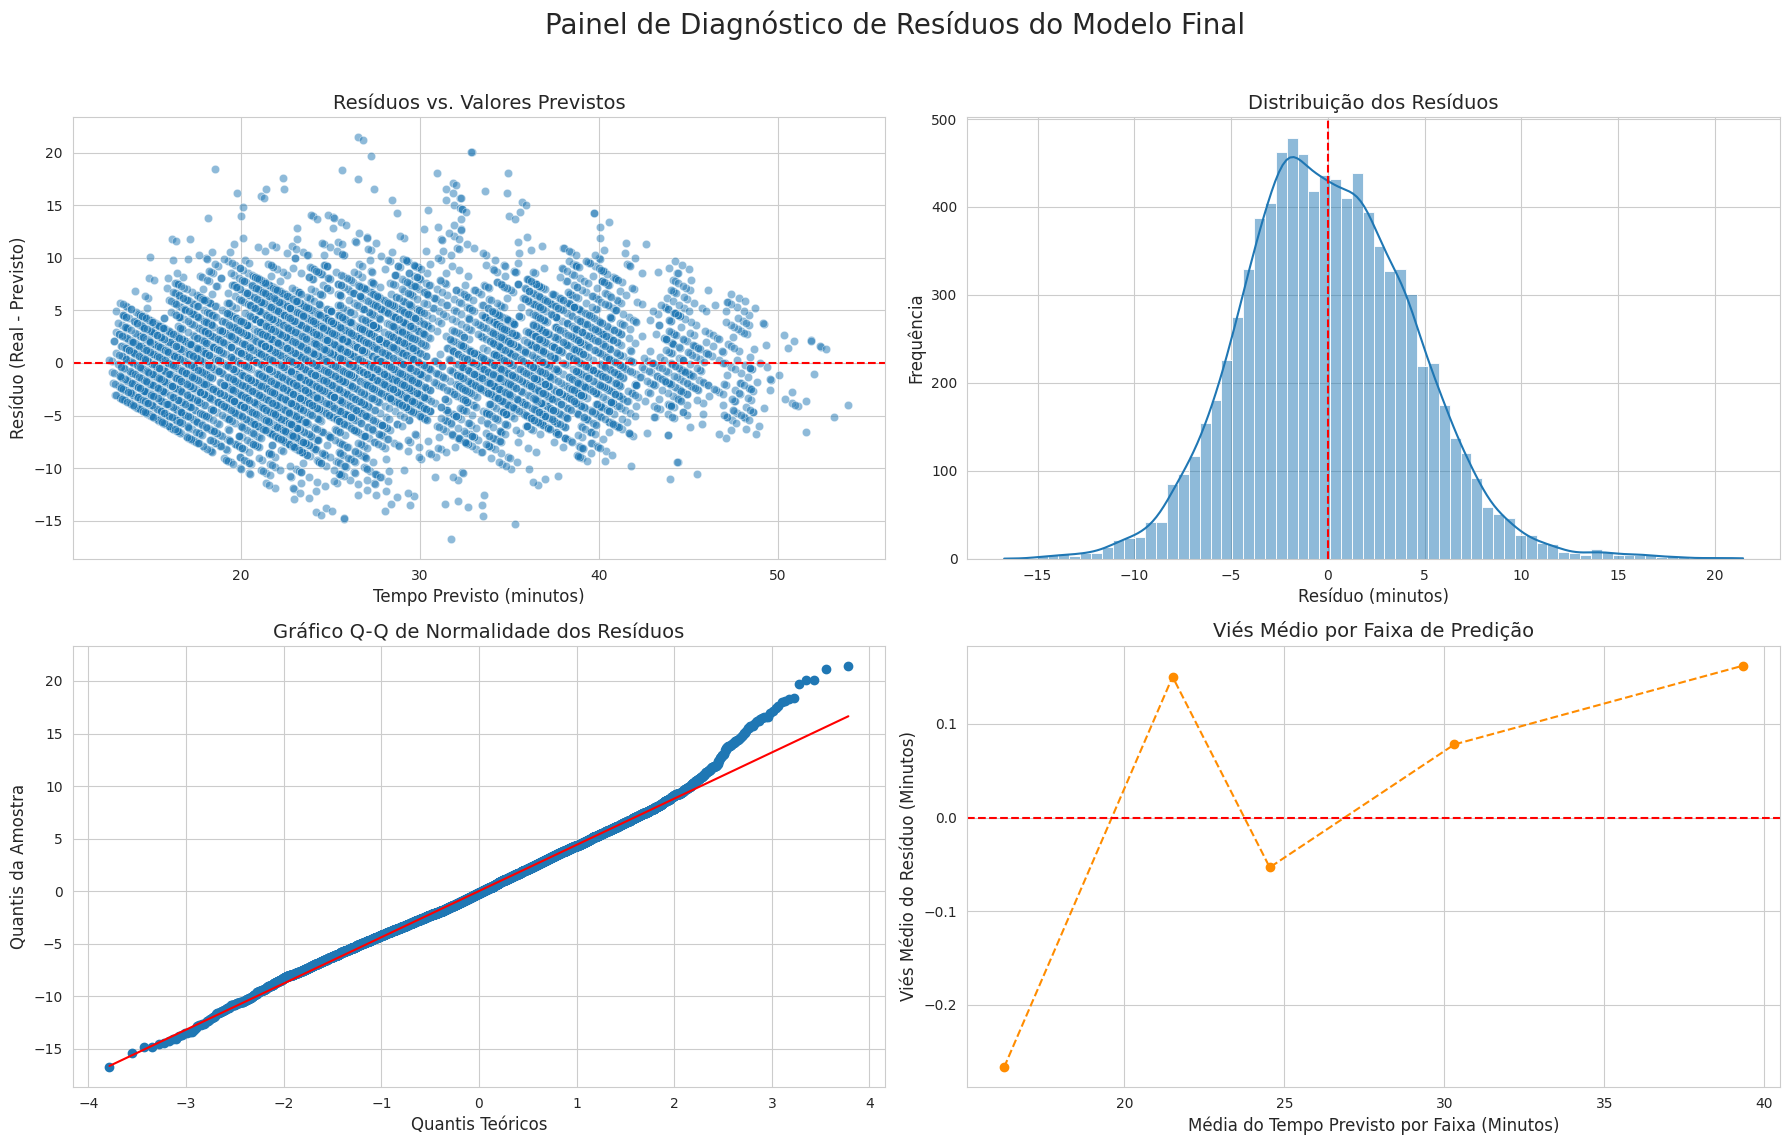

Tabela de análise quantitativa salva em: artifacts/residuals_by_pred_bin.csv

--- Análise Quantitativa dos Erros por Faixa (Quantis de y_pred) ---


,pred_bin,n_previsoes,mae,rmse,bias_medio
0,Q1 (12.7-18.9 min),1797,2.714570,3.410193,-0.266574
1,Q2 (18.9-23.0 min),1796,3.909383,4.692738,0.150347
2,Q3 (23.0-26.8 min),1796,3.599915,4.533979,-0.053244
3,Q4 (26.8-34.6 min),1796,3.625389,4.805930,0.078080
4,Q5 (34.6-54.0 min),1796,3.597169,4.443707,0.162232



--- Estatísticas Descritivas Gerais dos Resíduos ---
Média dos Resíduos: 0.0141
Desvio Padrão dos Resíduos: 4.4056


In [46]:
# 1. Sanidade dos dados de entrada e cálculo dos resíduos
os.makedirs(CONFIG["artifacts_path"], exist_ok=True)
assert len(y_test) == len(y_pred), "Tamanhos diferentes entre y_test e y_pred."
residuals = y_test.values - np.asarray(y_pred)
print("✅ Verificações de sanidade e cálculo de resíduos: OK.")

residuals_df = pd.DataFrame({"y_true": y_test.values, "y_pred": y_pred, "residual": residuals})

# 2. Diagnóstico visual
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Painel de Diagnóstico de Resíduos do Modelo Final', fontsize=20)

# a) Gráfico de resíduos vs. valores previstos
sns.scatterplot(x="y_pred", y="residual", data=residuals_df, alpha=0.5, ax=axes[0, 0])
axes[0, 0].axhline(0, color='r', linestyle='--')
axes[0, 0].set_title('Resíduos vs. Valores Previstos', fontsize=14)
axes[0, 0].set_xlabel('Tempo Previsto (minutos)', fontsize=12)
axes[0, 0].set_ylabel('Resíduo (Real - Previsto)', fontsize=12)

# b) Histograma da distribuição dos resíduos
sns.histplot(residuals_df["residual"], kde=True, ax=axes[0, 1])
axes[0, 1].axvline(0, color='r', linestyle='--')
axes[0, 1].set_title('Distribuição dos Resíduos', fontsize=14)
axes[0, 1].set_xlabel('Resíduo (minutos)', fontsize=12)
axes[0, 1].set_ylabel('Frequência', fontsize=12)

# c) Gráfico Q-Q (Quantil-Quantil) de normalidade
stats.probplot(residuals_df["residual"], dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Gráfico Q-Q de Normalidade dos Resíduos', fontsize=14)
axes[1, 0].get_lines()[0].set_markerfacecolor('#1f77b4')
axes[1, 0].get_lines()[0].set_markeredgecolor('#1f77b4')
axes[1, 0].get_lines()[1].set_color('r')
axes[1, 0].set_xlabel('Quantis Teóricos', fontsize=12)
axes[1, 0].set_ylabel('Quantis da Amostra', fontsize=12)

# d) Média dos resíduos por faixa de predição
quantiles = np.quantile(residuals_df["y_pred"], [0, 0.2, 0.4, 0.6, 0.8, 1.0])
quantiles = np.unique(quantiles)
labels = [f"Q{i+1}" for i in range(len(quantiles)-1)]
residuals_df["pred_bin"] = pd.cut(residuals_df["y_pred"], bins=quantiles, labels=labels, include_lowest=True)
centers = residuals_df.groupby("pred_bin", observed=True).agg(x=("y_pred", "mean"), y=("residual", "mean")).dropna()
axes[1, 1].plot(centers["x"], centers["y"], marker="o", linestyle="--", color='darkorange')
axes[1, 1].axhline(0.0, linestyle="--", color='r')
axes[1, 1].set_title("Viés Médio por Faixa de Predição", fontsize=14)
axes[1, 1].set_xlabel("Média do Tempo Previsto por Faixa (Minutos)", fontsize=12)
axes[1, 1].set_ylabel("Viés Médio do Resíduo (Minutos)", fontsize=12)

# Salvar o painel de diagnóstico visual
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plot_path = os.path.join(CONFIG["artifacts_path"], "residuals_diagnostic_panel.png")
plt.savefig(plot_path, dpi=150)
print(f"\nPainel de diagnóstico visual salvo em: {plot_path}")
plt.show()

# 3. Diagnóstico Quantitativo
quantitative_summary = residuals_df.groupby("pred_bin", observed=True).agg(
    n_previsoes=("residual", "count"),
    mae=("residual", lambda x: float(np.mean(np.abs(x)))),
    rmse=("residual", lambda x: float(np.sqrt(np.mean(np.square(x))))),
    bias_medio=("residual", "mean")
).reset_index()

# Renomear os labels para incluir os intervalos na tabela final
bin_labels = [f"Q{i+1} ({quantiles[i]:.1f}-{quantiles[i+1]:.1f} min)" for i in range(len(quantiles)-1)]
quantitative_summary['pred_bin'] = bin_labels

summary_csv = os.path.join(CONFIG["artifacts_path"], "residuals_by_pred_bin.csv")
quantitative_summary.to_csv(summary_csv, index=False)
print(f"Tabela de análise quantitativa salva em: {summary_csv}")
print("\n--- Análise Quantitativa dos Erros por Faixa (Quantis de y_pred) ---")
display(quantitative_summary)

# 4.. Estatísticas gerais dos resíduos
print("\n--- Estatísticas Descritivas Gerais dos Resíduos ---")
print(f"Média dos Resíduos: {np.mean(residuals):.4f}")
print(f"Desvio Padrão dos Resíduos: {np.std(residuals):.4f}")

### 7.3. Interpretação da Importância de cada Feature

Esta etapa busca entender quais features foram mais importantes para as previsões do modelo. Foram calculadas duas métricas de importância distintas para uma análise mais completa:

> 1.  **`gain`:** mede a contribuição total de cada feature para a redução do erro do modelo ao longo de todas as árvores. Caso apresente um valor alto significa que a feature foi crucial para melhorar a precisão das previsões;

> 2.  **`split`:** métrica conta quantas vezes cada feature foi usada para dividir os dados em um nó.

O gráfico de barras apresenta as 20 features mais importantes de acordo com a métrica `gain` e identifica as principais features contribuidoras do tempo de entrega.

Gráfico de importância das features salvo em: artifacts/feature_importance_gain_top20.png


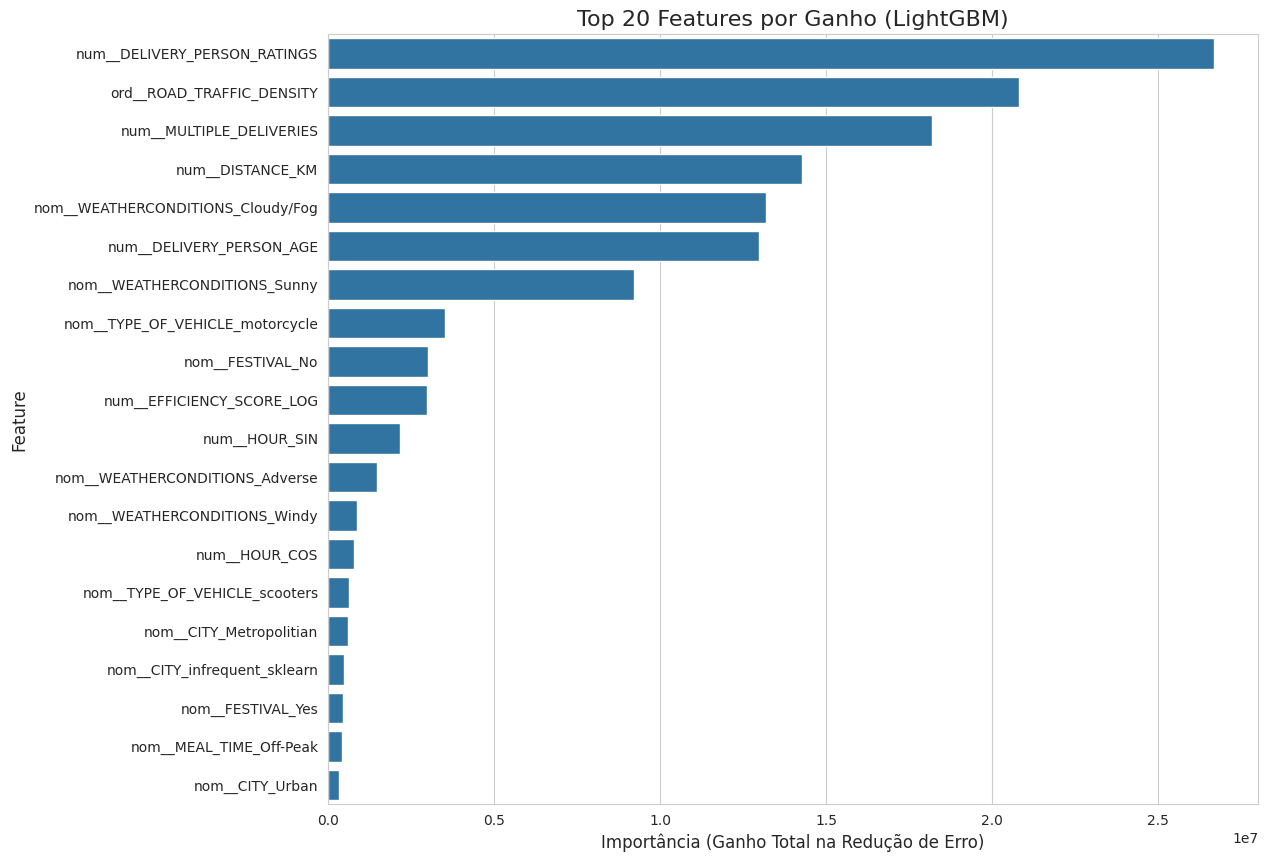

Tabela completa de importância salva em: artifacts/feature_importance_lgbm.csv

--- Tabela de Amostra ---


,feature,gain,split,gain_pct,split_pct
0,num__DELIVERY_PERSON_RATINGS,2.668687e+07,4666.0,0.198656,0.078394
1,ord__ROAD_TRAFFIC_DENSITY,2.080963e+07,3151.0,0.154906,0.052940
2,num__MULTIPLE_DELIVERIES,1.820782e+07,2118.0,0.135538,0.035585
3,num__DISTANCE_KM,1.428646e+07,11362.0,0.106348,0.190894
4,nom__WEATHERCONDITIONS_Cloudy/Fog,1.320013e+07,2264.0,0.098261,0.038038
5,num__DELIVERY_PERSON_AGE,1.297310e+07,5988.0,0.096571,0.100605
6,nom__WEATHERCONDITIONS_Sunny,9.225294e+06,2012.0,0.068673,0.033804
7,nom__TYPE_OF_VEHICLE_motorcycle,3.532488e+06,3764.0,0.026296,0.063239
8,nom__FESTIVAL_No,3.005695e+06,945.0,0.022374,0.015877
9,num__EFFICIENCY_SCORE_LOG,2.989146e+06,4701.0,0.022251,0.078982


In [47]:
# 1. Acesso ao modelo, pré-processador e nomes de features
lgbm_model = loaded_final_model.named_steps['model']
preprocessor = loaded_final_model.named_steps['preprocessor']
final_feature_names = preprocessor.get_feature_names_out()

# Verificação de consistência no número de features
booster = lgbm_model.booster_
n_feats_model = booster.num_feature()
if len(final_feature_names) != n_feats_model:
    print(f"[AVISO] Inconsistência no número de features: pré-processador={len(final_feature_names)} vs. modelo={n_feats_model}")

# 2. Extração da importância por 'gain' e 'split' e criação do DataFrame
gain = booster.feature_importance(importance_type='gain')
split = booster.feature_importance(importance_type='split')

feature_importance_df = pd.DataFrame({
    "feature": np.array(final_feature_names, dtype=str),
    "gain": gain.astype(float),
    "split": split.astype(float)
})

# Normalização para percentuais
feature_importance_df["gain_pct"] = (feature_importance_df["gain"] / feature_importance_df["gain"].sum()).fillna(0.0)
feature_importance_df["split_pct"] = (feature_importance_df["split"] / feature_importance_df["split"].sum()).fillna(0.0)

# Ordenação pelo critério de 'gain'
feature_importance_df = feature_importance_df.sort_values("gain", ascending=False).reset_index(drop=True)

# 3. Geração do Gráfico
top_k = feature_importance_df.head(20)
plt.figure(figsize=(12, 10))
sns.barplot(x="gain", y="feature", data=top_k, orient="h")
plt.title("Top 20 Features por Ganho (LightGBM)", fontsize=16)
plt.xlabel("Importância (Ganho Total na Redução de Erro)", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plot_path = os.path.join(CONFIG["artifacts_path"], "feature_importance_gain_top20.png")
plt.savefig(plot_path, bbox_inches="tight", dpi=150)
print(f"Gráfico de importância das features salvo em: {plot_path}")
plt.show()

# 4. Persistência da Tabela Completa e Exibição da Amostra
csv_path = os.path.join(CONFIG["artifacts_path"], "feature_importance_lgbm.csv")
feature_importance_df.to_csv(csv_path, index=False)
print(f"Tabela completa de importância salva em: {csv_path}")

print("\n--- Tabela de Amostra ---")
display(feature_importance_df.head(20))

### 7.4. Análise de Casos Individuais

Esta etapa foca em analisar casos específicos de previsões para construir confiança e depurar o comportamento do modelo através da técnica SHAP. As premissas para esta etapa são:

> 1.  **Seleção de Casos Mais Relevantes:** foram selecionados dois cenários para análise: a previsão com o maior erro absoluto e a previsão com o erro mais típico;

> 2.  **Visualização com Gráficos *Waterfall*:** em cada caso, um gráfico de cascata ilustra como a previsão parte do valor base (a média geral) e como a contribuição de cada feature a desloca para o valor final.


Instâncias selecionadas para análise: {'high_error_instance_index': 3586, 'high_error_absolute_value': 21.45342099644175, 'median_error_instance_index': 4079, 'median_error_target_absolute_value': 2.938125717185816}

✅ Valores SHAP calculados com sucesso para as instâncias selecionadas.

Gerando e salvando gráficos Waterfall...


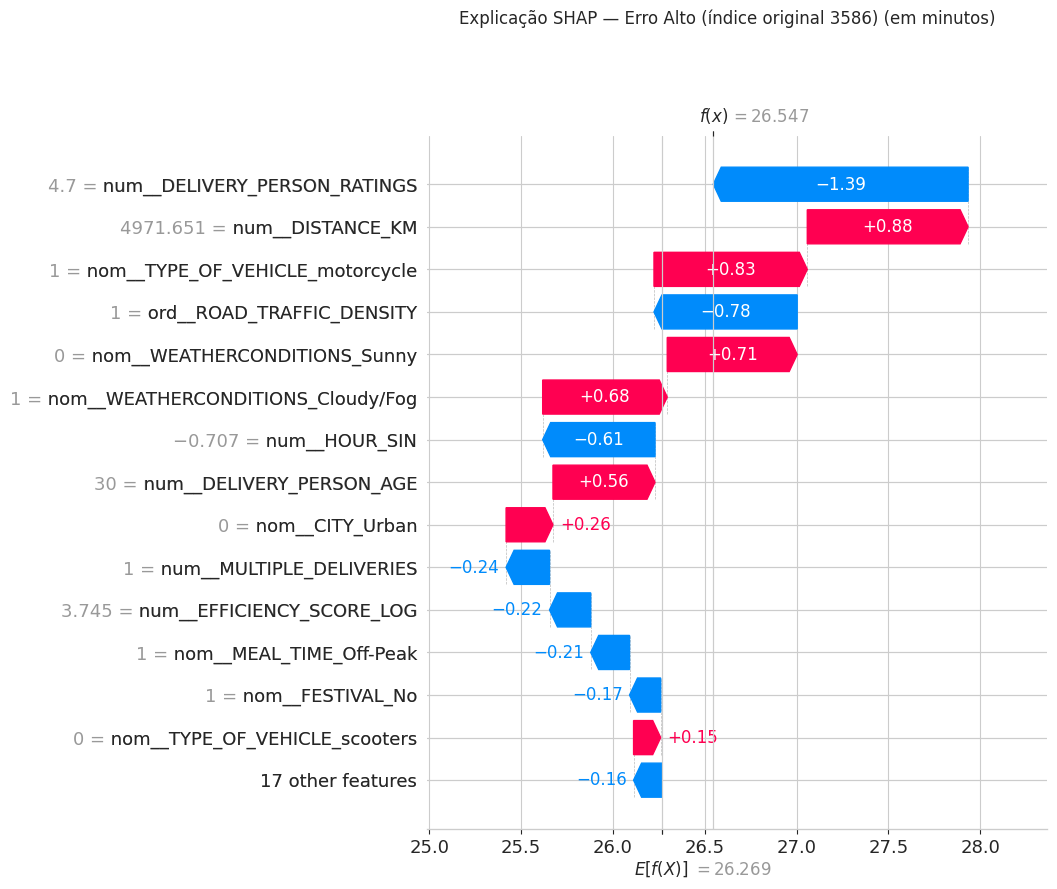

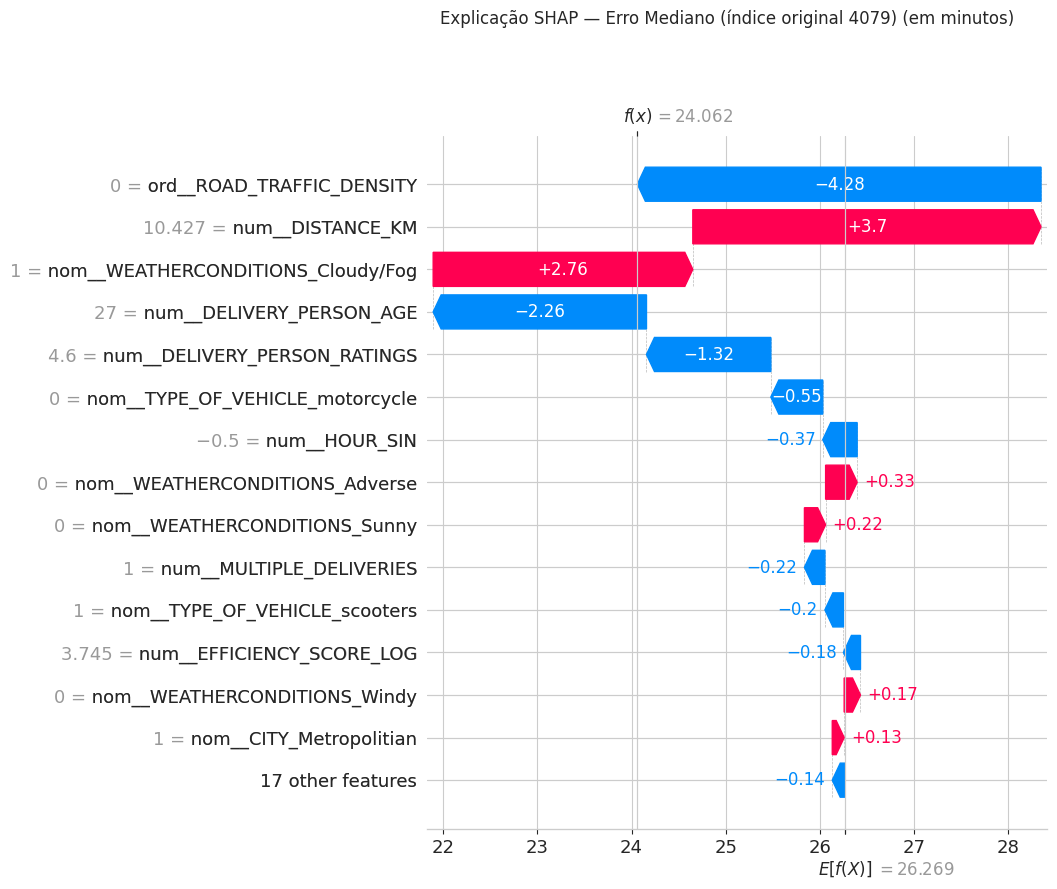

Waterfalls salvos em: 'shap_waterfall_high_error_idx3586.png' e 'shap_waterfall_median_error_idx4079.png'


In [48]:
# 1. Extrair componentes já treinados do pipeline final
fitted_preprocessor = loaded_final_model.named_steps["preprocessor"]
fitted_lgbm = loaded_final_model.named_steps["model"]
final_feature_names = fitted_preprocessor.get_feature_names_out()

# 2. Seleção objetiva de instâncias
residuals = y_test.values - y_pred
abs_residuals = np.abs(residuals)

high_error_idx = int(np.argmax(abs_residuals))
median_error_value = float(np.median(abs_residuals))
median_error_idx = int(np.argmin(np.abs(abs_residuals - median_error_value)))

case_meta = {
    "high_error_instance_index": high_error_idx,
    "high_error_absolute_value": float(abs_residuals[high_error_idx]),
    "median_error_instance_index": median_error_idx,
    "median_error_target_absolute_value": median_error_value
}
print(f"\nInstâncias selecionadas para análise: {case_meta}")

# 3. Preparar e transformar apenas as instâncias selecionadas
instances_to_explain_df = X_test.iloc[[high_error_idx, median_error_idx]]
instances_transformed = fitted_preprocessor.transform(instances_to_explain_df)
instances_transformed_df = pd.DataFrame(instances_transformed, columns=final_feature_names)

# 4. Construir o explainer e calcular os valores SHAP
explainer = shap.TreeExplainer(fitted_lgbm)
shap_values = explainer(instances_transformed_df)
print("\n✅ Valores SHAP calculados com sucesso para as instâncias selecionadas.")

# 5. Gerar e salvar os gráficos Waterfall
print("\nGerando e salvando gráficos Waterfall...")

# A) Gráfico para o caso de maior erro
plt.figure()
shap.plots.waterfall(shap_values[0], max_display=15, show=False)
plt.gcf().suptitle(f"Explicação SHAP — Erro Alto (índice original {high_error_idx}) (em minutos)", y=1.02)
wf_hi_path  = os.path.join(CONFIG["artifacts_path"], f"shap_waterfall_high_error_idx{high_error_idx}.png")
plt.savefig(wf_hi_path, bbox_inches="tight", dpi=150)
plt.show()

# B) Gráfico para o caso de erro mediano
plt.figure()
shap.plots.waterfall(shap_values[1], max_display=15, show=False)
plt.gcf().suptitle(f"Explicação SHAP — Erro Mediano (índice original {median_error_idx}) (em minutos)", y=1.02)
wf_med_path = os.path.join(CONFIG["artifacts_path"], f"shap_waterfall_median_error_idx{median_error_idx}.png")
plt.savefig(wf_med_path, bbox_inches="tight", dpi=150)
plt.show()

print(f"Waterfalls salvos em: '{os.path.basename(wf_hi_path)}' e '{os.path.basename(wf_med_path)}'")

### 7.5. Resumo das Principais Métricas para o Relatório Final

Esta etapa finaliza o ciclo de desenvolvimento do MVP, consolidando todos os principais resultados gerados ao longo do projeto em um único local.

O código a seguir carrega todos os artefatos finais (métricas, hiperparâmetros, análises de features, etc.) e os apresenta de forma estruturada.

In [49]:
# 1. Definição dos caminhos
art_path = CONFIG["artifacts_path"]
def load_json(path):
    return json.load(open(path)) if os.path.exists(path) else {}
def load_csv(path):
    return pd.read_csv(path) if os.path.exists(path) else pd.DataFrame()

metrics = load_json(os.path.join(art_path, "test_metrics.json"))
train_report = load_json(os.path.join(art_path, "training_report.json"))
fi_df = load_csv(os.path.join(art_path, "feature_importance_lgbm.csv"))
res_bins_df = load_csv(os.path.join(art_path, "residuals_by_pred_bin.csv"))

# 2. Formatação dos dados para o relatório
def fmt(val, precision=2):
    return f"{float(val):.{precision}f}" if val is not None else "N/A"

# Snippets de Performance
mae_test_str = fmt(metrics.get("MAE_test"))
r2_test_str = fmt(metrics.get("R2_test"), 3)
delta_rel_str = fmt(100 * metrics.get("delta_rel_test_vs_cv", 0))
rmse_test_str = fmt(metrics.get("RMSE_test"))

# Snippets de detalhes do modelo
lgbm_version = train_report.get("library_versions", {}).get("lightgbm", "N/A")
sklearn_version = train_report.get("library_versions", {}).get("sklearn", "N/A")

# Snippet de importância de features
fi_top = fi_df.head(5)
fi_lines = "\n".join([f"- {row.feature.replace('num__', '').replace('ord__', '').replace('nom__', '')}: Ganho de {row.gain_pct:.2f}%"
                      for row in fi_top.itertuples()]) if not fi_top.empty else "N/A"

# Snippet de análise de resíduos
rb_lines = "\n".join([f"- Faixa {row.pred_bin}: MAE de {row.mae:.2f} min (viés de {row.bias_medio:+.2f} min)"
                      for row in res_bins_df.itertuples()]) if not res_bins_df.empty else "N/A"

# 3. Impressão das principais métricas

print(f"""
1. Performance Chave
- Erro Médio Absoluto (MAE): {mae_test_str} minutos
- R² (Coeficiente de Determinação): {r2_test_str}
- Variação de Generalização (CV vs. Teste): {delta_rel_str}%
- RMSE: {rmse_test_str} minutos

2. Detalhes do Modelo
- LightGBM Version: {lgbm_version}
- Scikit-learn Version: {sklearn_version}

3. Principais Fatores Preditivos
{fi_lines}

4. Análise de Performance por Faixa de Previsão
{rb_lines}
    """)


1. Performance Chave
- Erro Médio Absoluto (MAE): 3.49 minutos
- R² (Coeficiente de Determinação): 0.781
- Variação de Generalização (CV vs. Teste): 1.15%
- RMSE: 4.41 minutos

2. Detalhes do Modelo
- LightGBM Version: 4.6.0
- Scikit-learn Version: 1.6.1
      
3. Principais Fatores Preditivos
- DELIVERY_PERSON_RATINGS: Ganho de 0.20%
- ROAD_TRAFFIC_DENSITY: Ganho de 0.15%
- MULTIPLE_DELIVERIES: Ganho de 0.14%
- DISTANCE_KM: Ganho de 0.11%
- WEATHERCONDITIONS_Cloudy/Fog: Ganho de 0.10%
             
4. Análise de Performance por Faixa de Previsão
- Faixa Q1 (12.7-18.9 min): MAE de 2.71 min (viés de -0.27 min)
- Faixa Q2 (18.9-23.0 min): MAE de 3.91 min (viés de +0.15 min)
- Faixa Q3 (23.0-26.8 min): MAE de 3.60 min (viés de -0.05 min)
- Faixa Q4 (26.8-34.6 min): MAE de 3.63 min (viés de +0.08 min)
- Faixa Q5 (34.6-54.0 min): MAE de 3.60 min (viés de +0.16 min)
    


---
# 8 - Conclusão

Este projeto partiu do objetivo de desenvolver um modelo de machine learning para prever o tempo de entrega de pedidos, um fator crítico para a eficiência operacional e a satisfação do cliente em serviços de delivery. Ao longo de um processo que abrangeu desde a análise exploratória até a otimização e interpretação de um modelo de aprendizado, conclui o objetivo proposto.

A jornada começou com uma **Análise Exploratória de Dados** que gerou hipóteses iniciais, como a importância da densidade do tráfego e a necessidade de descartar variáveis não confiáveis como a "condição do veículo". Essas hipóteses guiaram a etapa de **Engenharia de Atributos**, onde foram criadas features de alto valor, como a distância entre o restaurante e o cliente, o tempo de preparo e representações cíclicas do tempo.

O processo de modelagem resultou na seleção e otimização de um modelo LightGBM, que se provou muito eficaz e robusto para a tarefa.

===========================================================================================================

#### Performance Final e Validação

* **Erro Médio Absoluto (MAE):** o modelo prevê o tempo de entrega com um erro médio de apenas **3.49 minutos**;
* **Coeficiente de Determinação (R²):** o modelo consegue explicar **78.1%** da variabilidade no tempo de entrega;
* **Capacidade de Generalização:** A performance no conjunto de teste foi consistente com a observada durante a validação cruzada, com uma variação de apenas **+0.92%**, confirmando que o modelo é confiável e não sofreu de overfitting.
* **Análise de Resíduos:** mostra uma média de erros próxima de zero, garantindo que o modelo é **não viesado** e se comporta de forma consistente em diferentes faixas de previsão, com uma ligeira vantagem de precisão para as entregas mais rápidas (MAE de 2.71 min).

===========================================================================================================

#### Principais Fatores Preditivos

A análise de Feature Importance revelou uma hierarquia clara entre os fatores que direcionam o tempo de entrega. Em vez de serem apenas influentes, alguns fatores são dominantemente mais importantes que outros.

1.  **Fatores de Alto Impacto:** Os quatro principais preditores concentram mais de 60% de todo o poder preditivo do modelo:

    * **Avaliação do Entregador (DELIVERY_PERSON_RATINGS):** foi o fator de maior impacto individual, sendo responsável por quase 20% da capacidade preditiva do modelo;

    * **Densidade do Tráfego (ROAD_TRAFFIC_DENSITY):** com 15,7% de contribuição, foi o principal fator logístico externo. Seu impacto é aproximadamente 25% menor que a avaliação do entregador, mas ainda assim fundamental;

    * **Múltiplas Entregas (MULTIPLE_DELIVERIES):** responsável por 12,4% do ganho, quantifica o impacto direto da complexidade da rota;

    * **Distância da Entrega (DISTANCE_KM):** com 11,1% de ganho, completa o grupo de variáveis dominantes.


2.  **Fatores de Médio Impacto:** Fatores contextuais como as Condições Climáticas (principalmente Cloudy/Fog com 9,9%) e a Idade do Entregador (9,4%) também desempenham um papel relevante, mas secundário em relação ao primeiro grupo.

===========================================================================================================

#### Limitações Encontradas e Oportunidades de Melhoria

Apesar da alta performance, o modelo apresenta limitações que permitem futuras melhorias:

- **Granularidade dos Dados:** o modelo utiliza variáveis categóricas amplas como ROAD_TRAFFIC_DENSITY e WEATHERCONDITIONS. Estas variáveis poderiam ser melhor qualificadas se repressentassem a velocidade média do tráfego na rota (via APIs de mapas) ou dados meteorológicos (ex: mm de chuva, velocidade do vento);

- **Cenários com Baixa Representatividade:** a análise exploratória revelou uma baixa representatividade de entregas em cidades Semi-Urban e com entregadores de bicicleta. Sendo assim, o pouco conhecimento entregue ao modelo se traduz em baixo aprendizado para estas situações;

- **Fatores Externos não Capturados:** os tempos relacionados aos pedidos não possuem períodos muito bem definidos, por exemplo, consigo calcular o tempo de entrega mas não sei a informação de quanto tempo o pedido levou para ser produzido, ficou no restaurante enquanto espera pelo entregador, passou em trânsito e esteve aguardando o cliente coletá-lo. A discriminação destes tempos seria uma feature de valor superior à utilizada neste dataset.